# Attractor dynamics in the mouse cortex without structural signatures of attractors

Analysis code to reproduce all panels in figures 1 and 2 of the paper by Guarino, Filipchuk, Destexhe (2023)   
preprint link: https://www.biorxiv.org/content/10.1101/2022.05.24.493230v6

All this code is hosted on a github [repository](https://github.com/dguarino/Guarino-Filipchuk-Destexhe) (with a Zenodo DOI persistent identifier [here](https://zenodo.org)) and can be interactively executed here.  
The repository also contains a copy of the required data files from the [MICrONS project phase1](https://www.microns-explorer.org/phase1) (freely available on the project website), to ease the setup on Binder. 

This notebook performs loading and selection of the MICrONS data, structural and dynamical analyses, and plots the results as in the paper panels.

We divided the analysis code into:
- `imports_functions.py` : performs the imports and definition of various helper functions.
- `structural_analysis.ipynb` : creates a graph from the connectivity matrix and computes several graph measures (using [igraph](https://igraph.org)).
- `dynamical_analysis.ipynb` : performs population event analysis as in [Filipchuk et al. 2022](https://www.biorxiv.org/content/10.1101/2021.08.31.458322v2) and then also extracts core neurons of the events.


In [1]:
from platform import python_version
print(python_version())

from builtins import exec
exec(open("./imports_functions.py").read())

%matplotlib inline

3.10.4


## Loading curated data from MICrONS project phase 1

The following code for data loading and selection is taken from   
https://github.com/AllenInstitute/MicronsBinder/blob/master/notebooks/intro/MostSynapsesInAndOut.ipynb   
https://github.com/AllenInstitute/MicronsBinder/blob/master/notebooks/vignette_analysis/function/structure_function_analysis.ipynb

`Neurons.pkl` contains the `segment_id` for each pyramidal neuron in the EM volume.    
`Soma.pkl` contains the soma position for all the cells in the EM volume.   
`calcium_trace.pkl` contains the calcium imaging traces (including deconvolved spikes).    
`soma_subgraph_synapses_spines_v185.csv` contains the list of synapses with root pre-/post-synaptic somas.

In [2]:
if not os.path.exists("MICrONS_data/calcium_trace.pkl"):
    print("Downloading 2photon calcium traces ...")
    resp = wget.download("https://zenodo.org/record/5646567/files/calcium_trace.pkl?download=1", "MICrONS_data/calcium_trace.pkl")
    print("... Done: "+resp)
    
if os.path.exists("MICrONS_data/calcium_trace.pkl"):
    calcium_trace = pd.read_pickle("MICrONS_data/calcium_trace.pkl")
    calcium_trace_df = pd.DataFrame.from_dict(calcium_trace, orient='index')
# print(calcium_trace)
# print(calcium_trace_df.columns) # ['scan', 'trace_raw', 'trace', 'spike', 'stimulus']
# print(len(calcium_trace_df.index) ) # 112
# print(len(calcium_trace_df[calcium_trace_df['scan']==1].index))
# print(len(calcium_trace_df[calcium_trace_df['scan']==1].stimulus[648518346349539895]))

**CAUTION: The cell below might take some time to load the data.**

In [3]:
if not os.path.exists("MICrONS_data/pni_synapses_v185.csv"):
    print("Downloading Synapse table ...")
    resp = wget.download("https://zenodo.org/record/3710459/files/pni_synapses_v185.csv?download=1", "MICrONS_data/pni_synapses_v185.csv")
    print("... Done: "+resp)

if not os.path.exists("MICrONS_data/soma_subgraph_synapses_spines_v185.csv"):
    print("Downloading soma_subgraph_synapses_spines_v185 ...")
    resp = wget.download("https://zenodo.org/record/3710459/files/soma_subgraph_synapses_spines_v185.csv?download=1", "MICrONS_data/soma_subgraph_synapses_spines_v185.csv")
    print("... Done: "+resp)

with open("MICrONS_data/Neuron.pkl", 'rb') as handle:
    Neuron = pickle.load(handle)
with open("MICrONS_data/Soma.pkl", 'rb') as handle:
    Soma = pickle.load(handle)

syn_spines_df = pd.read_csv('MICrONS_data/soma_subgraph_synapses_spines_v185.csv')
# id, pre_root_id, post_root_id, cleft_vx, spine_vol_um3
print(syn_spines_df.shape)

syn_df = pd.read_csv('MICrONS_data/pni_synapses_v185.csv')
print(syn_df.shape)
# print(syn_df)

(1961, 17)
(3239275, 16)


Get the IDs and number of recorded pyramidal neurons

In [4]:
pyc_list = Neuron["segment_id"]
n_pyc = pyc_list.shape[0]

Set the folder to which all results will be saved, and the frame duration (from the MICrONS docs).

In [5]:
exp_path = os.getcwd()
frame_duration = 0.0674 # sec, 14.8313 frames per second

#### Accessing 2-photon Calcium imaging data subset

We are interested in reading only the Ca-imaging data of the cells for which also the EM reconstruction is available.   

##### CAUTION: next cell can take some time to load all calcium imaging data!

Pyramidal neurons recorded with 2-photon Calcium imaging:  112
27100
... producing spike rasterplot


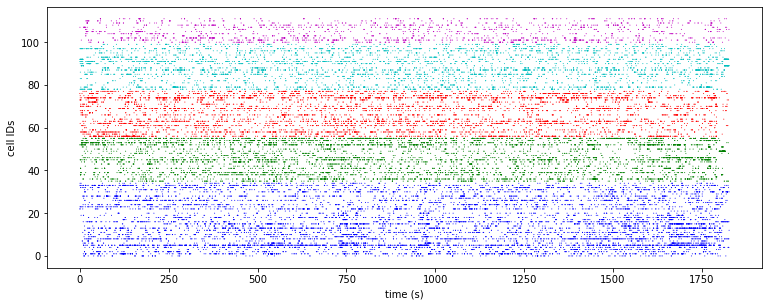

In [6]:
print("Pyramidal neurons recorded with 2-photon Calcium imaging: ",len(calcium_trace))
ophys_cell_ids = list(calcium_trace.keys())
n_frames = len(calcium_trace[ophys_cell_ids[0]]['spike'])
print(n_frames)
start_time = 0 # 200 frames of blank screen are already removed from the data
stop_time = (n_frames)*frame_duration
time = np.arange(start_time,stop_time,frame_duration)

traces = [[] for _ in range(5)] # five scans
spiketrains = [[] for _ in range(5)] # five scans
ophys_scan_ids = [[] for _ in range(5)] # five scans
for ocell_id in ophys_cell_ids:
    decst = calcium_trace[ocell_id]["spike"]
    traces[(calcium_trace[ocell_id]["scan"])-1].append( decst ) # deconvolved Ca
    spiketrains[(calcium_trace[ocell_id]["scan"])-1].append( time[:][np.nonzero(decst)]) # deconvolved Ca spiketrains
    ophys_scan_ids[(calcium_trace[ocell_id]["scan"])-1].append( ocell_id )

print("... producing spike rasterplot")
fig = plt.figure(figsize=[12.8,4.8])
rowg = 0
rowc = ['b','g','r','c','m']
for scanid,scan in enumerate(spiketrains):
    for row,train in enumerate(scan):
        plt.scatter( train, [row+rowg]*len(train), marker='o', edgecolors='none', s=1, c=rowc[scanid] )
    rowg += row+1
plt.ylabel("cell IDs")
plt.xlabel("time (s)")
plt.show()
fig.savefig(exp_path+'/results/rasterplot.png', transparent=False, dpi=800)
plt.close()
fig.clear()
fig.clf()

#### Create the cell indexes from the list of IDs

In [7]:
ophys_cell_indexes = range(len(ophys_cell_ids))

#### Get soma center locations

They are provided in voxels coordinates of 4,4,40 nm

In [8]:
pyc_soma_loc = np.zeros((n_pyc, 3))
for i in range(n_pyc):
    seg_id = pyc_list[i]
    pyc_soma_loc[i,:] = get_soma_loc(Soma, seg_id)

Join cell indexes with their position

In [9]:
pyc_ca_soma_loc = np.zeros((len(ophys_cell_indexes), 3))
for i in ophys_cell_indexes:
    seg_id = ophys_cell_ids[i]
    idx = np.where(pyc_list==seg_id)[0][0]
    pyc_ca_soma_loc[i,:] = pyc_soma_loc[idx,:]

### Adjacency matrix

First, we build an adjacency matrix for all the EM-imaged neurons:

In [10]:
adjacency_matrix = np.zeros((len(ophys_cell_indexes), len(ophys_cell_indexes)))

for i in ophys_cell_indexes:
    root_id = ophys_cell_ids[i]
    root_id_postsyn_list = syn_df[syn_df['pre_root_id'] == root_id]['post_root_id'].tolist()
    for ps in root_id_postsyn_list:
        if ps in ophys_cell_ids:
            ips = ophys_cell_ids.index(ps)
            adjacency_matrix[i][ips]=1
np.save(exp_path+'/results/adjacency_matrix.npy', adjacency_matrix)

Then we make also make 2p-scan-specific matrices:

In [11]:
scan_adjacency_matrix = {}
for scan_id in range(5):
    
    gshape = len(ophys_scan_ids[scan_id]) # num cells in the scan
    adjacency_matrix = np.zeros((gshape, gshape))
    
    for i,root_id in enumerate(ophys_scan_ids[scan_id]):
        root_id_postsyn_list = syn_df[syn_df['pre_root_id'] == root_id]['post_root_id'].tolist()
        for ps in root_id_postsyn_list:
            if ps in ophys_scan_ids[scan_id]:
                ips = ophys_scan_ids[scan_id].index(ps)
                adjacency_matrix[i][ips]=1
        scan_adjacency_matrix[scan_id] = adjacency_matrix
    
np.save(exp_path+'/results/scan_adjacency_matrix.npy', scan_adjacency_matrix)

## Are cells with correlated firing connected?

We first measure 1-lag correlation across all cells.   
Then, we mask the functional adjacency matrix using the EM connectivity matrix.    

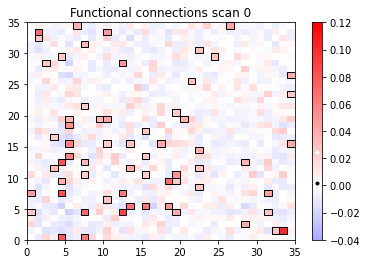

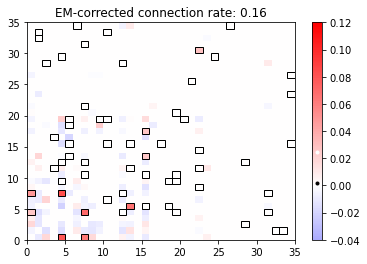

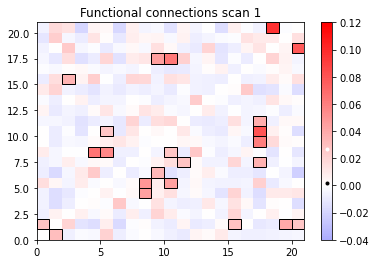

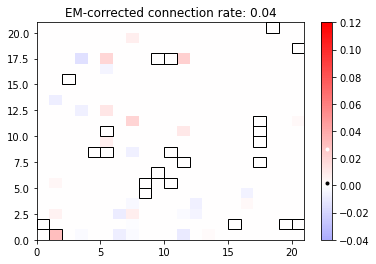

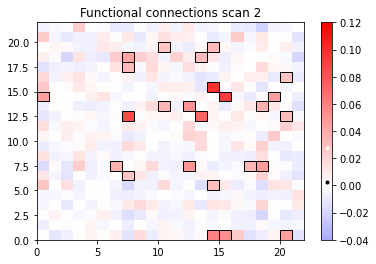

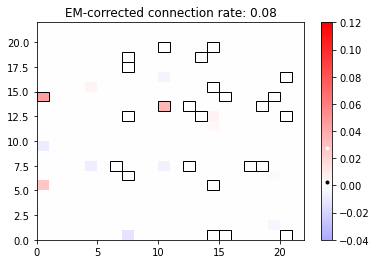

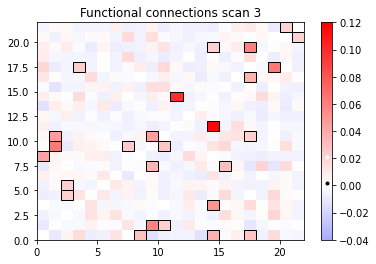

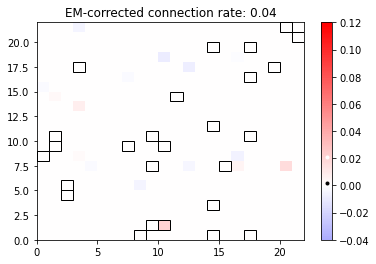

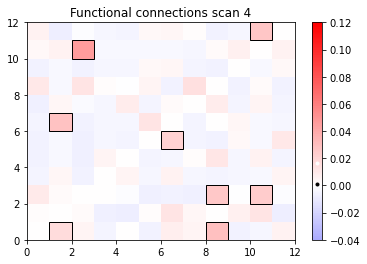

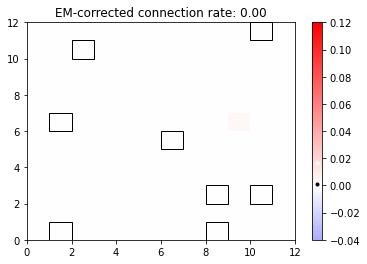

0.09722222222222222 (14/144)


In [12]:
tot_correlated = []
tot_connected = []
for scan_id,scan in enumerate(spiketrains):
    # make binary spiketrains
    binary_spiketrains = np.zeros( (len(scan),len(time)+2) )
    # print(binary_spiketrains.shape)
    
    for row,train in enumerate(scan):
        # iterate over spiketrains assigning 1 to the binary_spiketrains at the corresponding position
        tidxs = np.trunc(np.array(train)/frame_duration).astype(int)
        tidxs[tidxs>len(time)] = len(time) 
        binary_spiketrains[row][tidxs] = 1

    functional_adjacency_matrix = []
    for irow,bsti in enumerate(binary_spiketrains):
        row_xcorr = []
        for jrow,bstj in enumerate(binary_spiketrains):
            if irow==jrow:
                row_xcorr.append(0.0) # no self connections
                continue
            row_xcorr.append(crosscorrelation(bsti, bstj, maxlag=1, mode='corr')[2])
        functional_adjacency_matrix.append(row_xcorr)
    functional_adjacency_matrix = np.array(functional_adjacency_matrix)
    np.save(exp_path+"/results/functional_adjacency_matrix_%d.npy"%scan_id, functional_adjacency_matrix)
    
    # bootstrap confirms the percentile
    # print(functional_adjacency_matrix.mean(), np.percentile(functional_adjacency_matrix, 95))
    # func_percentile = []
    # for bi in range(1000):
    #     bootstrap_matrix = np.stack([np.random.choice(functional_adjacency_matrix.flatten(),size=functional_adjacency_matrix.shape[0],replace=False) for i in range(functional_adjacency_matrix.shape[0])])
    #     func_percentile.append(np.percentile(bootstrap_matrix, 95))
    # print(np.mean(func_percentile))
    
    # find mean and 95%, plot in on the colorbar, highlight which ones are above
    above95points = np.argwhere(functional_adjacency_matrix >= np.percentile(functional_adjacency_matrix,95))
    tot_correlated.extend(above95points)
    
    # plot
    fig = plt.figure()
    # norm = MidpointNormalize(vmin=np.amin(functional_adjacency_matrix), vmax=np.amax(functional_adjacency_matrix), midpoint=0)
    norm = MidpointNormalize(vmin=-0.04, vmax=0.12, midpoint=0)
    plt.pcolormesh(functional_adjacency_matrix, cmap='bwr', norm=norm)
    plt.title("Functional connections scan %d"%scan_id)
    ax = plt.gca()
    for ap in above95points:
        rect = patches.Rectangle((ap[1],ap[0]),1,1,linewidth=1,edgecolor='k',facecolor='none')
        ax.add_patch(rect)
    cbar = plt.colorbar()
    cbar.ax.plot(0.5, functional_adjacency_matrix.mean(), 'k.') 
    cbar.ax.plot(0.5, np.percentile(functional_adjacency_matrix,95), 'w.')
    plt.show()
    fig.savefig(exp_path+"/results/functional_adjacency_matrix_scan%d.png"%scan_id, transparent=True)
    plt.close()
    fig.clear()
    fig.clf()
    
    # masking
    maskedmatrix = functional_adjacency_matrix*scan_adjacency_matrix[scan_id]
    masked95points = np.argwhere(maskedmatrix >= np.percentile(functional_adjacency_matrix,95))
    tot_connected.extend(masked95points)

    # plot
    fig = plt.figure()
    # norm = MidpointNormalize(vmin=np.amin(maskedmatrix), vmax=np.amax(maskedmatrix), midpoint=0)
    norm = MidpointNormalize(vmin=-0.04, vmax=0.12, midpoint=0)
    plt.pcolormesh(maskedmatrix, cmap='bwr', norm=norm)
    plt.title("EM-corrected connection rate: %.2f"%(len(masked95points)/len(above95points)))
    ax = plt.gca()
    for ap in above95points:
        rect = patches.Rectangle((ap[1],ap[0]),1,1,linewidth=1,edgecolor='k',facecolor='none')
        ax.add_patch(rect)
    cbar = plt.colorbar()
    cbar.ax.plot(0.5, functional_adjacency_matrix.mean(), 'k.') 
    cbar.ax.plot(0.5, np.percentile(functional_adjacency_matrix,95), 'w.')
    plt.show()
    fig.savefig(exp_path+"/results/EMmasked_functional_adjacency_matrix_scan%d.png"%scan_id, transparent=True)
    plt.close()
    fig.clear()
    fig.clf()

# print(len(tot_correlated))
# print(tot_connected)
print(len(tot_connected)/len(tot_correlated), "(%d/%d)"%(len(tot_connected),len(tot_correlated)))

## Are co-tuned cells connected?
All scans were made using the same 16 orientations

In [13]:
print(np.unique(calcium_trace_df[calcium_trace_df['scan']==1].stimulus.tolist()))
print(np.unique(calcium_trace_df[calcium_trace_df['scan']==2].stimulus.tolist()))
print(np.unique(calcium_trace_df[calcium_trace_df['scan']==3].stimulus.tolist()))
print(np.unique(calcium_trace_df[calcium_trace_df['scan']==4].stimulus.tolist()))
print(np.unique(calcium_trace_df[calcium_trace_df['scan']==5].stimulus.tolist()))


[  0.   22.5  45.   67.5  90.  112.5 135.  157.5 180.  202.5 225.  247.5
 270.  292.5 315.  337.5   nan]
[  0.   22.5  45.   67.5  90.  112.5 135.  157.5 180.  202.5 225.  247.5
 270.  292.5 315.  337.5   nan]
[  0.   22.5  45.   67.5  90.  112.5 135.  157.5 180.  202.5 225.  247.5
 270.  292.5 315.  337.5   nan]
[  0.   22.5  45.   67.5  90.  112.5 135.  157.5 180.  202.5 225.  247.5
 270.  292.5 315.  337.5   nan]
[  0.   22.5  45.   67.5  90.  112.5 135.  157.5 180.  202.5 225.  247.5
 270.  292.5 315.  337.5   nan]


copying for ease

In [14]:
stimuli = [] 
for scan_id in range(5):
    stimuli.append( calcium_trace_df[calcium_trace_df['scan']==scan_id+1].head(1).stimulus.tolist()[0] )
print(len(stimuli[0])) # 27100, first 200 frames are used for the Df/f


27100


### Protocol
- 1 orientation out of 16 is presented during 15 frames
- followed by 40-41 frames of pink noise
- all orientations are randomly repeated 30 times (trials)

In [15]:
orientations = np.unique(stimuli[0])[:-1] # without the nan
print(orientations)
# print(list(stimuli[0]))
# print(np.argwhere(stimuli[0]==45.).tolist())
# print(np.argwhere(stimuli[4]==45.).tolist())

[  0.   22.5  45.   67.5  90.  112.5 135.  157.5 180.  202.5 225.  247.5
 270.  292.5 315.  337.5]


For all cells, we are going to compute:
- the *Orientation tuning* (ORT) as in [Ringach et al. 1997](https://pubmed.com):    
    $ORT = \frac{1}{T} \sum_{t}^{T} R_{td}$    
    where $T$ is the number of trials, $R_{td}$ is the number of spikes fired during one trial presentation of one stimulus with orientation $d$.
    
- the *Orientation Sensitivity Index* (OSI) as in [Ringach et al. 2002](https://pubmed.com):    
    $OSI = |\frac{\sum_{d}^{D} R_d * exp(i\frac{\pi}{4}d)}{\sum_{d}^{D} R_d}|$    
    where $R_i$ is the response during stimulus presentation $d$.    


First, we compute 100(or 1000) permuted spiketrains to test OSI significance.

In [16]:
surrogate_spiketrains = [[[] for j in range(len(ophys_scan_ids[i])) ] for i in range(5)] # 3d: scan, ori, intervals
# print(surrogate_spiketrains)

for scan_id in range(5):
    print("... entering reshuffling for", scan_id)
    for cidx,st in enumerate(spiketrains[scan_id]):
        spiketrainsISI = []
        spiketrainsISI.append( np.diff( st ) )
        # build surrogate rasterplots
        for isur in range(100):
            isi = spiketrainsISI.copy()
            random.shuffle(isi) # in-place function
            if len(isi): # init of timing of first spike
                spiketrainsISI[0] += start_time
            surrogate_spiketrains[scan_id][cidx].extend( np.cumsum(isi) ) # extend() to speed later
print("... done.")

... entering reshuffling for 0
... entering reshuffling for 1
... entering reshuffling for 2
... entering reshuffling for 3
... entering reshuffling for 4
... done.


OSI for 648518346349539895: 0.6432632756577449


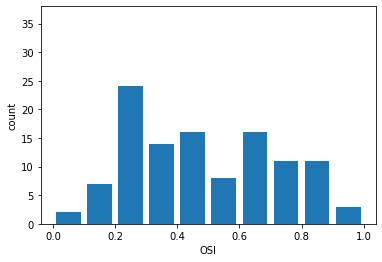

sOSI for 648518346349539895: 0.20000000000000007


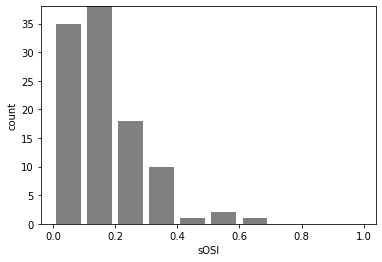

Tunings for 648518346349539895: [0.03333333333333333, 0.03333333333333333, 0.0, 0.03333333333333333, 0.0, 0.06666666666666667, 0.0, 0.0, 0.03333333333333333, 0.06666666666666667, 0.0, 0.0, 0.06666666666666667, 0.03333333333333333, 0.1, 0.03333333333333333]


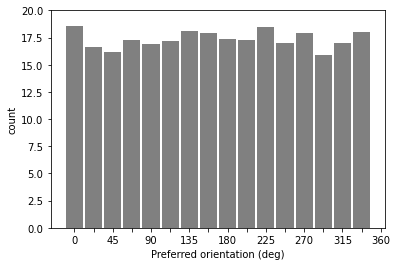

Tunings for 648518346349539895: [0.13333333333333333, 0.0, 0.0, 0.06666666666666667, 0.06666666666666667, 0.3333333333333333, 0.6, 0.2, 0.2, 0.03333333333333333, 0.0, 0.0, 0.03333333333333333, 0.5, 0.3333333333333333, 0.16666666666666666]


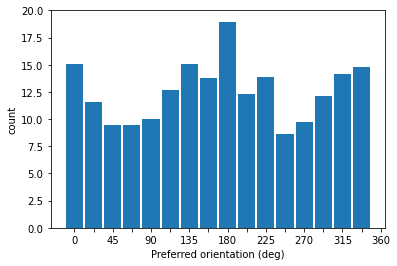

In [17]:
gOSI_cell_ids = dict.fromkeys(list(calcium_trace.keys()))
sOSI_cell_ids = dict.fromkeys(list(calcium_trace.keys()))
gORT_cell_ids = dict.fromkeys(list(calcium_trace.keys()))
sORT_cell_ids = dict.fromkeys(list(calcium_trace.keys()))

orientation_intervals = [[[] for i in range(16) ] for i in range(5)] # 3d: scan, ori, intervals
orientation_interval_frames = [[[] for i in range(16) ] for i in range(5)] # 3d: scan, ori, intervals
non_significant_cid = []

for scan_id in range(5):
    tdarray = np.zeros( (len(orientations),len(spiketrains[scan_id])) )
    surrogate_tdarray = np.zeros( (len(orientations),len(spiketrains[scan_id])) )
    for oridx,ori in enumerate(orientations):
        frames = np.argwhere(stimuli[scan_id]==ori)[:,0]
        # print(frames)
        # beginning frames for the presentation of this orientation 
        boundaries = [i for i in range(1, len(frames)) if frames[i] != frames[i-1]+1]
        intervals = []
        interframes = []
        first = 0
        for bstim in boundaries:
            intervals.append( (frames[first]*frame_duration, frames[bstim-1]*frame_duration) )
            interframes.append( (frames[first], frames[bstim-1]) )
            first = bstim
        intervals.append( (frames[first]*frame_duration, frames[-1]*frame_duration) ) # last
        interframes.append( (frames[first], frames[-1]) ) # last
        orientation_intervals[scan_id][oridx] = intervals
        orientation_interval_frames[scan_id][oridx] = interframes
        # print(intervals)
        # for each cell in this scan ...
        for cidx,cid in enumerate(ophys_scan_ids[scan_id]):
            # gather all spikes fired during the presentation of the current orientation
            for startstim,endstim in intervals:
                tdarray[oridx][cidx] += len([sp for sp in spiketrains[scan_id][cidx] if (startstim<sp and sp<=endstim)])
                # surrogates tuning
                ssp = surrogate_spiketrains[scan_id][cidx]
                surrogate_tdarray[oridx][cidx] += ((startstim<ssp)&(ssp<=endstim)).sum() 
    tdarray /= 30
    surrogate_tdarray /= 30*100

    for cidx,cid in enumerate(ophys_scan_ids[scan_id]):
        gORT_cell_ids[cid] = list(tdarray.T[cidx])
        sORT_cell_ids[cid] = list(surrogate_tdarray.T[cidx])
    
    # gOSI
    for cidx,cid in enumerate(ophys_scan_ids[scan_id]):
        OSI_cell = 0.0
        Rcell = 0.0
        for oridx,ori in enumerate(orientations):
            OSI_cell += tdarray[oridx][cidx] * np.exp(1j * (np.pi/4) * oridx)
            Rcell += tdarray[oridx][cidx]
        gOSI_cell_ids[cid] = np.abs( OSI_cell / Rcell )
    # sOSI
    for cidx,cid in enumerate(ophys_scan_ids[scan_id]):
        OSI_cell = 0.0
        Rcell = 0.0
        for oridx,ori in enumerate(orientations):
            OSI_cell += surrogate_tdarray[oridx][cidx] * np.exp(1j * (np.pi/4) * oridx)
            Rcell += surrogate_tdarray[oridx][cidx]
        sOSI_cell_ids[cid] = np.abs( OSI_cell / Rcell )

    # Which cells have an OSI below their surrogates?
    for cidx,cid in enumerate(ophys_scan_ids[scan_id]):
        # print(sOSI_cell_ids[cid], gOSI_cell_ids[cid])
        if sOSI_cell_ids[cid] >= gOSI_cell_ids[cid]:
            non_significant_cid.append(cid)

print("OSI for 648518346349539895:",gOSI_cell_ids[648518346349539895])
fig = plt.figure()
plt.hist(gOSI_cell_ids.values(), bins=10, range=(0.,1.), rwidth=0.8)
fig.canvas.draw()
plt.ylim([0,38])
plt.ylabel('count')
plt.xlabel('OSI')
plt.show()
fig.savefig(exp_path+'/results/OSI.png', transparent=True)
plt.close()
fig.clear()
fig.clf()

print("sOSI for 648518346349539895:",sOSI_cell_ids[648518346349539895])
fig = plt.figure()
plt.hist(sOSI_cell_ids.values(), bins=10, range=(0.,1.), rwidth=0.8, color="gray")
fig.canvas.draw()
plt.ylim([0,38])
plt.ylabel('count')
plt.xlabel('sOSI')
plt.show()
fig.savefig(exp_path+'/results/sOSI.png', transparent=True)
plt.close()
fig.clear()
fig.clf()

print("Tunings for 648518346349539895:",sORT_cell_ids[648518346349539895])
fig = plt.figure()
barori = np.array([0. for _ in range(16)])
for cid,oris in sORT_cell_ids.items():
    barori += oris
plt.bar(range(len(barori)), barori, 0.9, color="gray")
fig.canvas.draw()
plt.ylim([0,20])
plt.ylabel('count')
plt.xlabel('Preferred orientation (deg)')
plt.xticks(range(17),['0','','45','','90','','135','','180','','225','','270','','315','','360'])
plt.show()
fig.savefig(exp_path+'/results/sORI.png', transparent=True)
plt.close()
fig.clear()
fig.clf()
                                                      
print("Tunings for 648518346349539895:",gORT_cell_ids[648518346349539895])
fig = plt.figure()
barori = np.array([0. for _ in range(16)])
for cid,oris in gORT_cell_ids.items():
    barori += oris
plt.bar(range(len(barori)), barori, 0.9)
fig.canvas.draw()
plt.ylim([0,20])
plt.ylabel('count')
plt.xlabel('Preferred orientation (deg)')
plt.xticks(range(17),['0','','45','','90','','135','','180','','225','','270','','315','','360'])
plt.show()
fig.savefig(exp_path+'/results/ORI.png', transparent=True)
plt.close()
fig.clear()
fig.clf()

The surrogates need to be converted in cell significance of OSI and exclude the cell non-significantly tuned from the count below.

In [18]:
print(non_significant_cid)

[648518346349538527, 648518346349539423, 648518346349534072, 648518346349537814, 648518346349539892, 648518346349536366, 648518346349538730, 648518346349539096, 648518346349535074, 648518346349536851, 648518346349533252, 648518346349537741]


### So, are co-tuned cells connected?
The classical [Ko et al. 2011](https://www.nature.com/articles/nature09880) (Fig. 2d) results show that co-tuned cells are preferably connected (left below).     
![Ko et al. 2011, Fig. 2d](resources/Ko2011_Fig2d.png "Ko et al. 2011, Fig. 2d") 

However, the results should be evaluated in full (donut chart below). Over 16 mice, 126 cells in total were recorded, 116 cells both *in-vivo* and *in-vitro*. Of the remaining cells, 94 were orientation selective, and 26 were connected. Of these, 10 were co-tuned (orientation preference delta within 22.5 deg).     
Please, note the modest quantity of cells that are orientation-selective **and** connected compared to those orientation selective (donut chart below). 

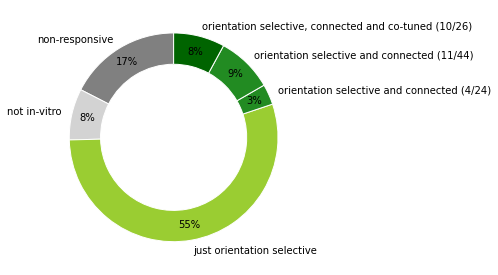

In [19]:
Ko_data = np.array([[0., 0., 22., 10.], [69., 4., 11., 10.]])
Ko_labels = [None, None, 'non-responsive', 'not in-vitro', 'just orientation selective', 'orientation selective and connected (4/24)', 'orientation selective and connected (11/44)', 'orientation selective, connected and co-tuned (10/26)']

fig, ax = plt.subplots(figsize=[12.8,4.8])
size = 0.3 # to have wedges
outer_colors = ['gray','yellowgreen']
inner_colors = ['gray','gray','gray','lightgray', 'yellowgreen','forestgreen','forestgreen','darkgreen']
# ax.pie(vals.sum(axis=1), radius=1-size, autopct='%1.f%%', startangle=90, pctdistance=0.8, colors=outer_colors, wedgeprops=dict(width=size, edgecolor='w'))
ax.pie(Ko_data.flatten(), radius=1, labels=Ko_labels, autopct=lambda pct:'{:1.0f}%'.format(pct) if pct > 0 else '', startangle=90, pctdistance=0.85, colors=inner_colors, wedgeprops=dict(width=size, edgecolor='w'))
plt.show()
fig.savefig(exp_path+'/results/Ko_chart.png', transparent=True, dpi=190)
plt.close()
fig.clear()
fig.clf()

In addition, although in [Turner et al. 2022](https://doi.org/10.1016/j.cell.2022.01.023) it is reported a positive correlation between mean response to preferred directions and connections (Fig. 7H), this is only because of a **linear** fit. If [weighted least squares](http://www.itl.nist.gov/div898/handbook/pmd/section4/pmd432.htm) or [generalized least squares](https://en.wikipedia.org/wiki/Generalized_least_squares) were used to weight the outliers (here circled in red), the fit (in dashed red) would be different.    
![Turner et al. 2022, Fig. 7H](resources/Turner2022_Fig7h.png "Turner et al. 2022, Fig. 7H")   

Here, we do the same analysis as Ko et al. on the MICrONS data:

all OSI cells: 112
significant OSI cells: 100
Connection probability between pairs of same orientation-tuned neurons: 0.06 (6/100)


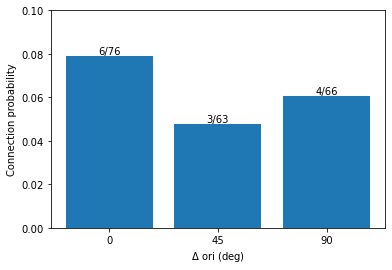

In [20]:
ort_df = pd.DataFrame.from_dict(gORT_cell_ids, orient='index')
# print(ort_df.shape)
# print(ort_df)

# find best orientation tuning for each cell
cell_max_ort = ort_df.idxmax(axis=1).to_dict()
# print(cell_max_ort)

# how many co-tuned cells?
rev_max_ort = {} # 
for key, value in cell_max_ort.items():
     rev_max_ort.setdefault(value, set()).add(key)
rev_max_ort = dict(sorted(rev_max_ort.items()))
# cotuned_cells = [(key,values) for key,values in rev_max_ort.items() if len(values) > 1] 
cotuned_cells = [values for key,values in rev_max_ort.items() if len(values) > 1] 
# print(cotuned_cells)

# how many co-tuned are connected?
same_ort_connected_tot = 0
ort45_ort_connected_tot = 0
ort90_ort_connected_tot = 0
same_ort_connected = 0
ort45_ort_connected = 0
ort90_ort_connected = 0
for cellid, ori in cell_max_ort.items():
    # print(cellid, ori)
    
    if cellid in non_significant_cid: # comment this line to have the total (use the commented bars with 'gray' color below to plot)
        continue
    # print(cellid)
    
    # cycle through cell ids
    postsyn_list = syn_df[syn_df['pre_root_id'] == cellid]['post_root_id'].tolist()
    for ps in postsyn_list:
        if ps==cellid:
            continue
        if ps in cell_max_ort and cell_max_ort[ps]==cell_max_ort[cellid]:
            # print("same ort:",ps)
            same_ort_connected += 1 
            same_ort_connected_tot += len(cotuned_cells[ori])
        if ps in cell_max_ort and (cell_max_ort[ps]==cell_max_ort[cellid]+2 or cell_max_ort[ps]==cell_max_ort[cellid]+2):
            # print("45 deg apart ort:",ps) 
            ort45_ort_connected += 1 
            ort45_ort_connected_tot += len(cotuned_cells[ori+2])+len(cotuned_cells[ori-2])
        if ps in cell_max_ort and (cell_max_ort[ps]==cell_max_ort[cellid]+4 or cell_max_ort[ps]==cell_max_ort[cellid]+4):
            # print("90 deg apart ort:",ps) 
            ort90_ort_connected += 1
            ort90_ort_connected_tot += len(cotuned_cells[ori+4])+len(cotuned_cells[ori-4])

print("all OSI cells:", len(gOSI_cell_ids.items()))
OSI_significant = [v for k,v in gOSI_cell_ids.items() if k not in non_significant_cid]
print("significant OSI cells:", len(OSI_significant))

# print(same_ort_connected,ort45_ort_connected,ort90_ort_connected)
# print(same_ort_connected_tot,ort45_ort_connected_tot,ort90_ort_connected_tot)
ort_connected = (same_ort_connected+ort45_ort_connected+ort90_ort_connected)
ort_tot_connected = (same_ort_connected_tot+ort45_ort_connected_tot+ort90_ort_connected_tot)
print("Connection probability between pairs of same orientation-tuned neurons:", same_ort_connected/len(OSI_significant), "(%d/%d)"%(same_ort_connected,len(OSI_significant)))
                             
fig = plt.figure()
mbar = plt.bar(range(3), [same_ort_connected/same_ort_connected_tot, ort45_ort_connected/ort45_ort_connected_tot, ort90_ort_connected/ort90_ort_connected_tot], 0.8, color="C0", zorder=3)
# mbar = plt.bar(range(3), [same_ort_connected/same_ort_connected_tot, ort45_ort_connected/ort45_ort_connected_tot, ort90_ort_connected/ort90_ort_connected_tot], 0.8, color="gray", zorder=3)
# plt.hlines(ort_connected/ort_tot_connected, -0.5,2.5, linestyle='--', color="gray", zorder=1)
fig.canvas.draw()
plt.ylim([0,0.1])
plt.ylabel('Connection probability')
plt.xlabel(r'$\Delta$ ori (deg)')
plt.xticks(range(3),['0','45','90'])
for rect,con,otot in zip(mbar,[same_ort_connected, ort45_ort_connected, ort90_ort_connected],[same_ort_connected_tot, ort45_ort_connected_tot, ort90_ort_connected_tot]):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{con}/{otot}', ha='center', va='bottom')
plt.show()
fig.savefig(exp_path+'/results/conn_ori.png', transparent=True)
plt.close()
fig.clear()
fig.clf()

Using the quantities we just compute, we can ask the statistical independence of the connection probability between cells with different orientations. We find that there is no significant trend (Chi-squared statistical independence).     
Moreover, even if the quantities were different and the trend was there, we should again consider this information in light of the modest quantity of cells that are orientation-selective and connected (donut chart below). 

Chi-squared statistical independence: 2.814644590754769
p-value: 0.8317254321296013


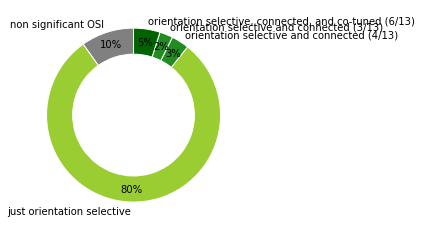

In [21]:
ORT_connected_sign_couples = [76, 63, 66]
ORT_connected_sign_cellid = [6, 3, 4]
ORT_connected_all_couples = [87, 85, 99] # from the cell above, not commenting the filtering by OSI-significant cells
ORT_connected_all_cellid = [7, 4, 6]
(statistic,pvalue,dof,expected_freqndarray) = stats.chi2_contingency([ORT_connected_sign_cellid, ORT_connected_all_cellid, ORT_connected_sign_couples, ORT_connected_all_couples])
print("Chi-squared statistical independence:", statistic)
print("p-value:", pvalue)

MICrONS_data = np.array([len(non_significant_cid), len(OSI_significant)-len(ORT_connected_sign_cellid), 4., 3., 6.])
MICrONS_labels = ['non significant OSI', 'just orientation selective', 'orientation selective and connected (4/13)', 'orientation selective and connected (3/13)', 'orientation selective, connected, and co-tuned (6/13)']
fig, ax = plt.subplots(figsize=[9,4])
size = 0.3 # to have wedges
inner_colors = ['gray', 'yellowgreen', 'forestgreen', 'forestgreen', 'darkgreen']
ax.pie(MICrONS_data, radius=1, labels=MICrONS_labels, autopct=lambda pct:'{:1.0f}%'.format(pct) if pct > 0 else '', startangle=90, pctdistance=0.85, colors=inner_colors, wedgeprops=dict(width=size, edgecolor='w'))
plt.show()
fig.savefig(exp_path+'/results/MICrONS_chart.png', transparent=True, dpi=300)
plt.close()
fig.clear()
fig.clf()

---
# Structural analysis

This part deals with the purely structural description of the portion of VISp cortex L2/3 considered in the MICrONS dataset.    
In particular, we want to know whether it has a structural property supposed to be common to all cortices: *hierarchical modularity* -- where cells have dense connectivity with other cells within the same module and sparse connectivity with cells in other modules ([Meunier et al. 2009](https://doi.org/10.3389/neuro.11.037.2009), [Newman 2010](https://academic.oup.com/book/27303)).    
It is possible to infer hierarchical modularity also from functional connectivity(see [Sadovsky and MacLean 2013](https://www.jneurosci.org/content/33/35/14048)).    
Here, we tested the compatibility between functionally-derived and EM-derived hierarchical modularity, whihc allows us to generalize our findings to the whole cortex.

In [22]:
global_degree_counts = []
global_degree_distribution = []
global_structural_betweeness = []
global_structural_motifs = []
global_structural_motifsratio = []
global_structural_motifsurrogates = []

%run "structural_analysis.ipynb"

global_structural_betweeness.append(betweenness_centrality)
global_degree_counts.append(degree_counts)
global_degree_distribution.append(degrees)
global_structural_motifs.append(motifs)
global_structural_motifsurrogates.append(surrogate_motifs)
global_structural_motifsratio.append(motifsratio)

334
    number of vertices: 334
... Network nodes degrees
... Degree distributions
... Local Clustering Coefficient
... Betweenness centrality
... Motifs


/tmp/ipykernel_50/2963444990.py:28: RuntimeWarning: invalid value encountered in true_divide
  motifsratio = motifs/surrogate_motifs


---
## Dynamical Analysis

If you consider (I share your concern) that the 2-photon temporal resolution is a problem for single cell responses, I believe (you may not share my belief) that the frame duration of the MICrONS L2/3 dataset is enough to have a (partial, at least) view of the cortical population response, which takes hundreds of ms to build up.   

Here below we will be looking into reproducible firing patterns and their stimulus-dependence.    
All panels of Figure 1 are produced in the next cell by the `dynamical_analysis.ipynb`.    
Several figures will be saved directly to the forlder `results` without being showed inline here. Please take a look at the ipynb file to know the filenames and whet they mean.

#### Replotting spiketrains
with stimulus times added

In [23]:
# rowc = ['b','g','r','c','m']
# for scanid,(scan,oris) in enumerate(zip(spiketrains,orientation_intervals)):
#     height = len(scan)*0.042857142857143
#     fig, ax = plt.subplots(figsize=(12.8,height))
#     for row,train in enumerate(scan):
#         ax.scatter( train, [row]*len(train), marker='o', edgecolors='none', s=1, c=rowc[scanid] )
#     for stim in oris:
#         for times in stim:
#             ax.axvspan(times[0], times[1], alpha=0.1, linewidth=0, facecolor='grey', zorder=1)
#     plt.ylabel("cell IDs")
#     plt.xlabel("time (s)")
#     fig.savefig(exp_path+"/results/rasterplot_scan%d.png"%scanid, transparent=False, dpi=1800)
#     plt.close()
#     fig.clear()
#     fig.clf()

In [24]:
global_structural_motif_cores = {k: 0 for k in range(16)}
global_structural_motif_others = {k: 0 for k in range(16)}
global_events = [[] for i in range(5)] # by scan
global_events_sec = []
global_events_duration = []
global_cluster_number = []
global_cluster_selfsimilarity = []
global_cluster_tuning = {k:{} for k in range(16)} # by orientation
global_surrogate_cluster_tuning = {k:{} for k in range(16)} # by orientation
global_tot_clusters = [[] for i in range(5)] # by scan
global_clustered_spectrums = []

core_reproducibility_perc = 60 # threshold for detecting cores

for scan_id,scan_spiketrains in enumerate(spiketrains):
    print("scan: ",scan_id)
    ophys_cell_ids = ophys_scan_ids[scan_id]
    ophys_cell_indexes = range(len(ophys_cell_ids))
    
    %run "dynamical_analysis.ipynb"

    global_events_sec.append(events_sec)
    global_events_duration.extend(events_durations_f)
    global_cluster_number.append(nclusters)
    global_cluster_selfsimilarity.extend(reproducibility_list)
    print()


scan:  0
    population firing: 0.40±0.65 sp/frame
    cells firing rate: 0.01±0.11 sp/s
... generating surrogates to establish population event threshold
... loaded surrogates
    event size threshold (mean): 2.018052946814365
... find population events in the trial
... signatures of population events
    number of events: 83
    number of events per sec: 0.0454411072300634
    events duration: 0.674±0.240
    events size: 5.000±1.496
... Similarity of events matrix
... clustering
    linkage
    surrogate events signatures for clustering threshold
    cluster reproducibility threshold: 0.30468919887369783
    cluster size threshold: 2
    Total number of clusters: 17
    # clusters (after removing those below reproducibility threshold): 7
... finding cluster cores
    removing cores firing unspecifically
    gathering cores from all clusters
    # cores: 19
    # non-cores: 16
    cores per cluster: 4.00±1.94 (min 0, max 7)
    others per cluster: 31.00±1.94 (min 28, max 35)

scan:  

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


    cells firing rate: 0.01±0.12 sp/s
... generating surrogates to establish population event threshold
... loaded surrogates
    event size threshold (mean): 2.00773238733685
... find population events in the trial
... signatures of population events
    number of events: 54
    number of events per sec: 0.029564093860523177
    events duration: 0.708±0.242
    events size: 4.000±1.181
... Similarity of events matrix
... clustering
    linkage
    surrogate events signatures for clustering threshold
    cluster reproducibility threshold: 0.36028478070542547
    cluster size threshold: 2
    Total number of clusters: 10
    # clusters (after removing those below reproducibility threshold): 3
... finding cluster cores
    removing cores firing unspecifically
    gathering cores from all clusters
    # cores: 6
    # non-cores: 15
    cores per cluster: 1.50±1.50 (min 0, max 3)
    others per cluster: 19.50±1.50 (min 18, max 21)

scan:  2
    population firing: 0.27±0.53 sp/frame
    cel

### Are there stimulus-specific reproducible patterns?
We counted the total number of statistically significant reproducible patterns (in `global_tot_clusters`).    
We also counted the events within these patterns that were evoked by stimuli. An event was considered to be triggered by a stimulus if it started after the stimulus presentation and no later than 10 frames after the presentation (~640ms, two third of the inter-stimulus period).

We created (100) surrogate event timings and performed surrogate event specificity for stimuli.    
Here, we convert those occurrences into a significance threshold probability.

In [25]:
# print(global_surrogate_cluster_tuning)
surrogates_cluster_tuning = []
significance_cluster_tuning = []
for oridx,clcs in global_surrogate_cluster_tuning.items():
    for clcolor_scan,clcount in clcs.items():
        clcolor,scan_id = clcolor_scan.split(",")
        significance_cluster_tuning.append( (clcount/global_tot_clusters[int(scan_id)][1][global_tot_clusters[int(scan_id)][0].index(clcolor)])/100 )
        surrogates_cluster_tuning.append(clcount/100)
print("Significance threshold probability for event occurrence: %.2f±%.2f"%(np.mean(significance_cluster_tuning),np.std(significance_cluster_tuning)))

Significance threshold probability for event occurrence: 0.03±0.02


Significant orientation-tuned patterns: 3 for #orientations: 7


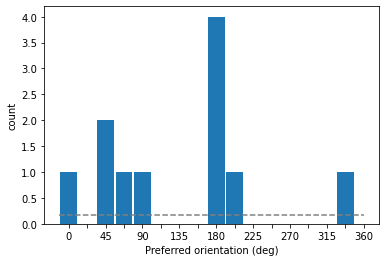

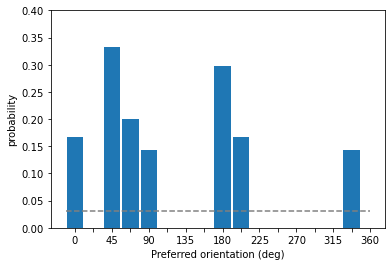

In [26]:
occurrences_cluster_tuning = [0 for i in range(16)]
probabilities_cluster_tuning = [0 for i in range(16)]

# print(global_cluster_tuning)
# print(global_tot_clusters)
for oridx,clcs in global_cluster_tuning.items():
    # print("orientation:",oridx)
    occurrences = 0
    probabilities = 0
    for clcolor_scan,clcount in clcs.items():
        clcolor,scan_id = clcolor_scan.split(",")
        occurrences += clcount
        probabilities += clcount/global_tot_clusters[int(scan_id)][1][global_tot_clusters[int(scan_id)][0].index(clcolor)]
    if len(clcs.items())>0:
        occurrences_cluster_tuning[oridx] = occurrences
        probabilities_cluster_tuning[oridx] = probabilities/len(clcs.items())

print("Significant orientation-tuned patterns:", len(np.unique(clustered_event_colors)), "for #orientations:", len(np.array(probabilities_cluster_tuning)[np.array(probabilities_cluster_tuning)>0.]))
    
fig = plt.figure()
plt.bar(range(len(occurrences_cluster_tuning)), occurrences_cluster_tuning, 0.9)
fig.canvas.draw()
plt.hlines(np.mean(surrogates_cluster_tuning), -0.5,16, linestyle='--', color="gray", zorder=1)
plt.ylabel('count')
plt.xlabel('Preferred orientation (deg)')
plt.xticks(range(17),['0','','45','','90','','135','','180','','225','','270','','315','','360'])
plt.show()
fig.savefig(exp_path+'/results/pattern_ORI_occurrences.png', transparent=True)
plt.close()
fig.clear()
fig.clf()

fig = plt.figure()
plt.bar(range(len(probabilities_cluster_tuning)), probabilities_cluster_tuning, 0.9)
fig.canvas.draw()
plt.ylim([0,0.4])
plt.hlines(np.mean(significance_cluster_tuning), -0.5,16, linestyle='--', color="gray", zorder=1)
plt.ylabel('probability')
plt.xlabel('Preferred orientation (deg)')
plt.xticks(range(17),['0','','45','','90','','135','','180','','225','','270','','315','','360'])
plt.show()
fig.savefig(exp_path+'/results/pattern_ORI_probabilities.png', transparent=True)
plt.close()
fig.clear()
fig.clf()


#### What is the tuning of cells participating to population events?
We count the number of cells participating in orientation-tuned patterns by their tuning $\Delta$.     
The cells participating to reproducible patterns are not necessarily co-oriented with the stimulus but the majority is within 45 degrees.

orientation: 0 {'#80ffb4,4': 1}
Probability of same orientation-tuned neurons recruted in an orientation-tuned pettern: 0.16666666666666666 (1/6)


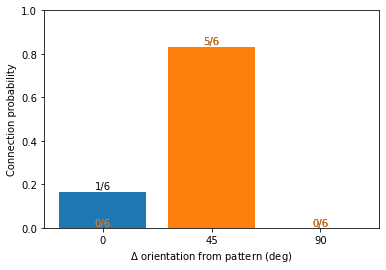

orientation: 2 {'#ff5f30,0': 2}
Probability of same orientation-tuned neurons recruted in an orientation-tuned pettern: 0.4 (2/5)


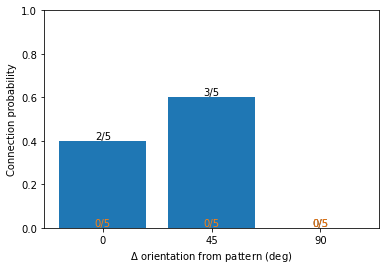

orientation: 3 {'#00b5eb,0': 1}
Probability of same orientation-tuned neurons recruted in an orientation-tuned pettern: 0.5 (3/6)


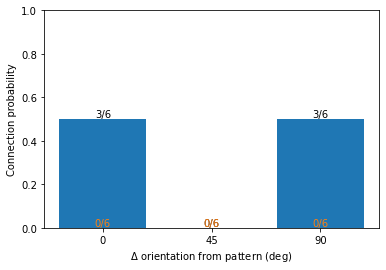

orientation: 4 {'#ff0000,0': 1}
Probability of same orientation-tuned neurons recruted in an orientation-tuned pettern: 0.14285714285714285 (3/21)


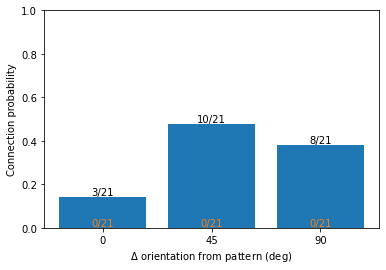

orientation: 8 {'#80ffb4,0': 3, '#ff7e41,4': 1}
Probability of same orientation-tuned neurons recruted in an orientation-tuned pettern: 0.21739130434782608 (5/23)


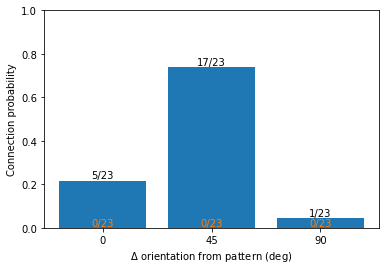

orientation: 9 {'#80ffb4,4': 1}
Probability of same orientation-tuned neurons recruted in an orientation-tuned pettern: 0.0 (0/2)


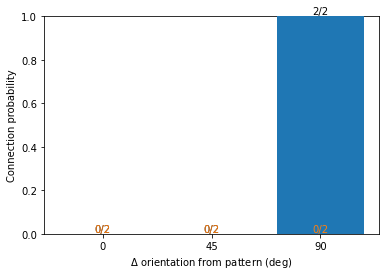

orientation: 15 {'#80ffb4,0': 1}
Probability of same orientation-tuned neurons recruted in an orientation-tuned pettern: 0.0 (0/1)


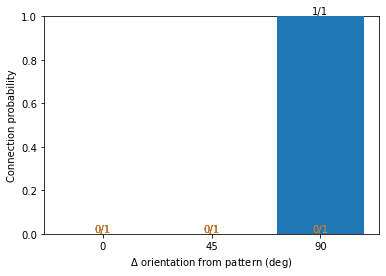

Total probability of same orientation-tuned neurons recruted in an orientation-tuned pettern: 0.21875 (14/64)


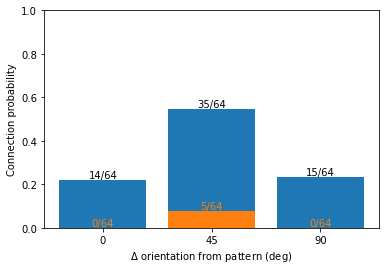

In [27]:
same_ort_tot = 0
ort45_ort_tot = 0
ort90_ort_tot = 0
core_same_ort_tot = 0
core_ort45_ort_tot = 0
core_ort90_ort_tot = 0

for oridx,clcs in global_cluster_tuning.items():    
    if not len(clcs):
        continue
    print("orientation:",oridx, clcs)

    same_ort = 0
    ort45_ort = 0
    ort90_ort = 0
    core_same_ort = 0
    core_ort45_ort = 0
    core_ort90_ort = 0

    for clcolor_scan,clcount in clcs.items():
        clcolor,scan_id = clcolor_scan.split(",")
        if clcolor_scan in global_clustered_spectrums[int(scan_id)].keys():
            for cluster_events_cellids in global_clustered_spectrums[int(scan_id)][clcolor_scan]:
                for cellid in cluster_events_cellids:
                    # print(cellid, np.argmax(sORT_cell_ids[cellid])) # cell's orientation best response
                    # print(cellid in clusters_cores_by_color[clcolor])
                    if np.argmax(sORT_cell_ids[cellid]) == oridx:
                        same_ort += 1
                        same_ort_tot += 1
                        if clcolor in clusters_cores_by_color and cellid in clusters_cores_by_color[clcolor]:
                            core_same_ort += 1
                            core_same_ort_tot += 1
                    if np.argmax(sORT_cell_ids[cellid])+2 == oridx or np.argmax(sORT_cell_ids[cellid])-2 == oridx:
                        ort45_ort += 1
                        ort45_ort_tot += 1
                        if clcolor in clusters_cores_by_color and cellid in clusters_cores_by_color[clcolor]:
                            core_ort45_ort += 1
                            core_ort45_ort_tot += 1
                    if np.argmax(sORT_cell_ids[cellid])+4 == oridx or np.argmax(sORT_cell_ids[cellid])-4 == oridx:
                        ort90_ort += 1
                        ort90_ort_tot += 1
                        if clcolor in clusters_cores_by_color and cellid in clusters_cores_by_color[clcolor]:
                            core_ort90_ort += 1
                            core_ort90_ort_tot += 1

    # print(same_ort,ort45_ort,ort90_ort)
    ort = (same_ort+ort45_ort+ort90_ort)
    print("Probability of same orientation-tuned neurons recruted in an orientation-tuned pettern:", same_ort/ort, "(%d/%d)"%(same_ort,ort))

    fig = plt.figure()
    mbar = plt.bar(range(3), [same_ort/ort, ort45_ort/ort, ort90_ort/ort], 0.8, color="C0", zorder=3)
    corebar = plt.bar(range(3), [core_same_ort/ort, core_ort45_ort/ort, core_ort90_ort/ort], 0.8, color="C1", zorder=4)
    fig.canvas.draw()
    plt.ylim([0,1.])
    plt.ylabel('Connection probability')
    plt.xlabel(r'$\Delta$ orientation from pattern (deg)')
    plt.xticks(range(3),['0','45','90'])
    for rect,con,otot in zip(mbar,[same_ort, ort45_ort, ort90_ort],[ort, ort, ort]):
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{con}/{otot}', ha='center', va='bottom')
    for rect,con,otot in zip(corebar,[core_same_ort, core_ort45_ort, core_ort90_ort],[ort, ort, ort]):
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{con}/{otot}', ha='center', va='bottom', color="C1")
    plt.show()
    fig.savefig(exp_path+"/results/pattern_ori%s.png"%(oridx), transparent=True)
    plt.close()
    fig.clear()
    fig.clf()

ort_tot = (same_ort_tot+ort45_ort_tot+ort90_ort_tot)
print("Total probability of same orientation-tuned neurons recruted in an orientation-tuned pettern:", same_ort_tot/ort_tot, "(%d/%d)"%(same_ort_tot,ort_tot))

fig = plt.figure()
mbar = plt.bar(range(3), [same_ort_tot/ort_tot, ort45_ort_tot/ort_tot, ort90_ort_tot/ort_tot], 0.8, color="C0", zorder=3)
corebar = plt.bar(range(3), [core_same_ort_tot/ort_tot, core_ort45_ort_tot/ort_tot, core_ort90_ort_tot/ort_tot], 0.8, color="C1", zorder=4)
fig.canvas.draw()
plt.ylim([0,1.])
plt.ylabel('Connection probability')
plt.xlabel(r'$\Delta$ orientation from pattern (deg)')
plt.xticks(range(3),['0','45','90'])
for rect,con,otot in zip(mbar,[same_ort_tot, ort45_ort_tot, ort90_ort_tot],[ort_tot, ort_tot, ort_tot]):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{con}/{otot}', ha='center', va='bottom')
for rect,con,otot in zip(corebar,[core_same_ort_tot, core_ort45_ort_tot, core_ort90_ort_tot],[ort_tot, ort_tot, ort_tot]):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{con}/{otot}', ha='center', va='bottom', color="C1")
plt.show()
fig.savefig(exp_path+"/results/pattern_ori.png", transparent=True)
plt.close()
fig.clear()
fig.clf()


---
## Fixed-point attractor analysis

It has been proposed (by Carrillo-Reid and Yuste, among others) that reproducible patterns are attractors of the cortical dynamics. By the methods used to characterize these "attractors" it is understood that [fixed-point attractors](https://en.wikipedia.org/wiki/Attractor#Fixed_point) are meant. 

Usually the presence of attractors is justified by showing the reproducibility of some patterns. Here, we test their presence using more stringent methods. We base our treatment of the concept of attractor on the work of [Milnor 1985](https://link.springer.com/article/10.1007/BF01212280). To search for attractors in experimental data (no characteristic equation given), we will use the approach outlined by [Andy Wuensche](http://www.ddlab.com/boa_idea.html).

For a network of size $N$ ($N$-dimensional), we use the joint activity of its $N$ units at each time-point $t$ to characterise its dynamics.      
An example **state** is $B = [1,0,1,0,...,0,1,1,0]$.    
The *state-space* - the space of all possible bitstrings or patterns - is made of all $2^n$ states.   

A **trajectory** in state-space, is made of $B$, its *predecessor* $A$, and its *successor* $C$. The state $B$ may have other predecessor states besides $A$, the total is the *in-degree*.

An **attractor** is a subset of the state-space such that:
1. It is *forward invariant*: if one state is part of a trajectory leading to the attractor, its next state should be part of the trajectory as well.
1. It has a *neighborhood*: a set of in-degree predecessors.
1. No subset of the trajectory has the above two properties. 

In our case, 
- a *state* is a 2-photon frame sample (64ms), with $N$ being the number of imaged cells
- a *population event* is a *set of states*, which might or not be a *trajectory*
- a *fixed-point attractor* is represented by a series of population events (trajectories)   

where population events and clusters of events are defined by the above procedure (in `dynamical_analysis.ipynb`).    

#### How to search for dynamical attractors in the MICrONS dataset
If it is true that reproducible population event patterns are attactors of the cortical dynamic, they should be already visible  adopting a common strategy of dimensionality reduction (e.g. through PCA).

We should find that:
- If the events clustered are realizations of an attractor, then the states constituting each event should 
    1. form a trajectory (property 1 above)
    1. be linked in a chain of predecessors-successors, i.e. a trajectory (beginning of property 2 above)
- If trajectories are found, they should form a *transient-tree*, a set of nested trajectories, also called *basin of attraction*. In particular, we should:
    3. find that several trajectories are lying over the same principal component axes (completion of property 2 above).

We will be using sklearn preprocessing and decomposition libraries. All figures below are interactive, to enable closer inspection.

In [28]:
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import to_rgb, to_rgba, to_hex
import seaborn as sns

%matplotlib widget

#### State characterization
Each state is colored according to its participation in the events identified above.     
By default, they are transparent lightgray, to allow their visual inspection.      
**Note that the cell below will take time to compute all state properties.**

In [29]:
ecolors = [[(*to_rgb('lightgray'), 0.01) for j in range(len(traces[0][0]))] for i in range(5)] # clustered population events
scolors = [[(*to_rgb('lightgray'), 0.01) for j in range(len(traces[0][0]))] for i in range(5)] # stimulus presentations
for scan_id in range(5):
    for iframe,_ in enumerate(ecolors[scan_id]):
        for event in global_events[scan_id]:
            # if iframe>=event['start'] and iframe<=event['end'] and event['color']!='gray':
            if iframe>=event['start'] and iframe<=event['end']:
                ecolors[scan_id][iframe] = (*to_rgb(event['color']), 0.9)
        # orientation_interval_frames to plot colored edges for stimulated dots                
        for stimframes in orientation_interval_frames[scan_id]:
            for timeframes in stimframes:
                # print(timeframes[0], timeframes[1])
                if iframe>=timeframes[0] and iframe<=timeframes[1] and ecolors[scan_id][iframe]!=(0.8274509803921568, 0.8274509803921568, 0.8274509803921568, 0.01):
                    scolors[scan_id][iframe] = (*to_rgb('black'), 0.9)

#### Trajectories
We also want to draw lines showing the temporal sequence of states (only for clusters, for readability).

In [41]:
elines = [[] for i in range(5)]
elinescolors = [[] for i in range(5)]
for scan_id in range(5):
    frames = np.unique(np.argwhere( np.array([*ecolors[scan_id]]) != (0.8274509803921568, 0.8274509803921568, 0.8274509803921568, 0.01) )[:,0])
    # print(frames)
    # beginning frames for the presentation of this orientation 
    boundaries = [i for i in range(1, len(frames)) if frames[i] != frames[i-1]+1]
    first = 0
    for beginning in boundaries:
        elines[scan_id].append( (frames[first], frames[beginning-1]) )
        elinescolors[scan_id].append( ecolors[scan_id][frames[first]] )
        first = beginning
    elines[scan_id].append( (frames[first], frames[beginning-1]) ) # last
    elinescolors[scan_id].append( ecolors[scan_id][frames[first]] )
# print(elines)

#### Dimensionality reduction
We will use the deconvolved (continuous) traces to perform the PCA and define states.     
The deconvolved (continuous) 2-photon frame sample trace from each neuron will compose a (continuous) N-dimensional vector.
We will perform PCA over these states and then inspect the states corresponding to the clustered events.

What you will see below are four plots for each scan.

The **explained variance** of each variable (cell) is low (first panel for each scan). 

However, this is due to the fact that the **contribution to each component** of the variables (cells) is not linear, which is why we can still use the PCA.

If we take the first **two principal components**, we see that even in this flattened version the clustered events are separable. States that were identified (in the dynamical_analysis) as belonging to different clusters are colored as above. States that occurred during stimulus presentations have a black edge.

If we take the first **three principal components**, we see that event states follow trajectories. For each scan, by zooming and panning, it is possible to follow individual trajectories (line colors are assigned randomly) for different sets of states belonging to different events in clusters (colors and edges as for the previous plot).

scan: 0    #cells: 35


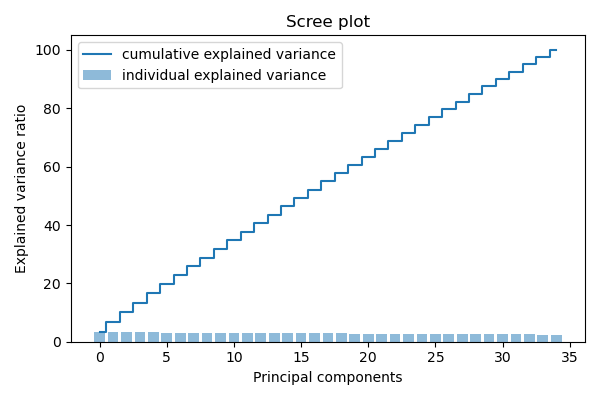

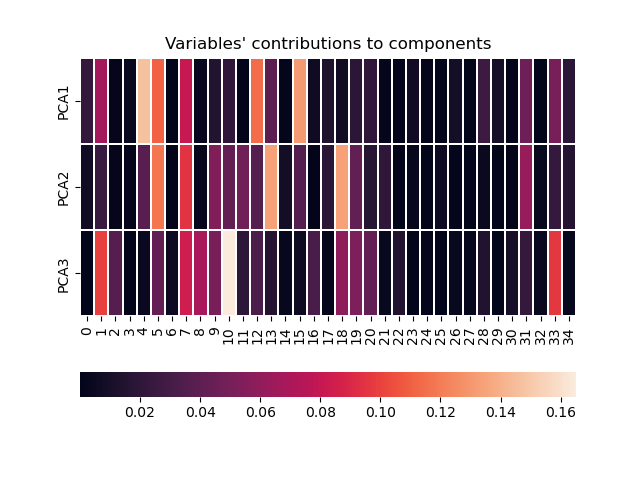

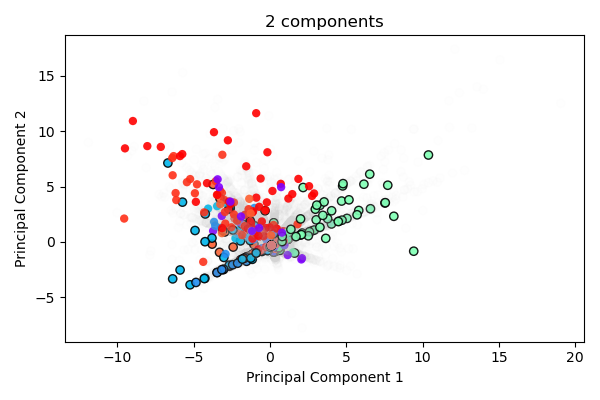

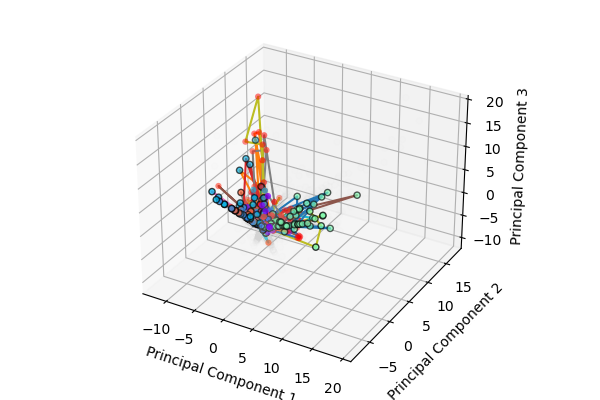

scan: 1    #cells: 21


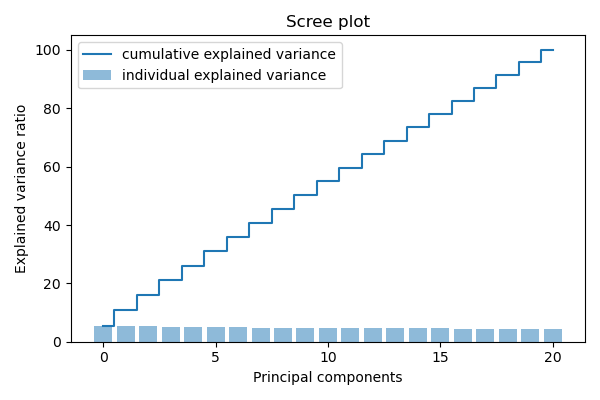

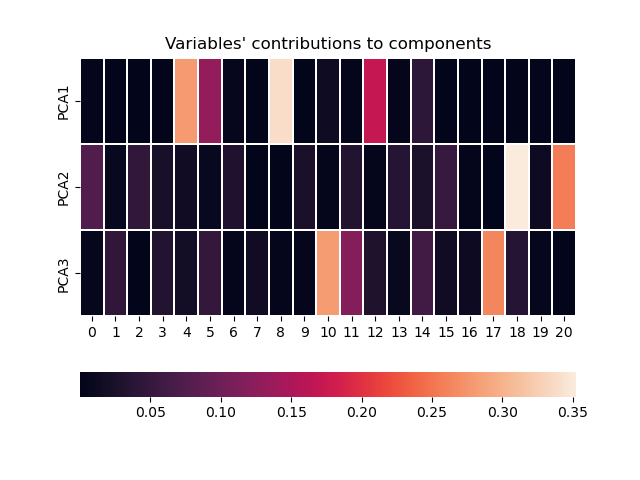

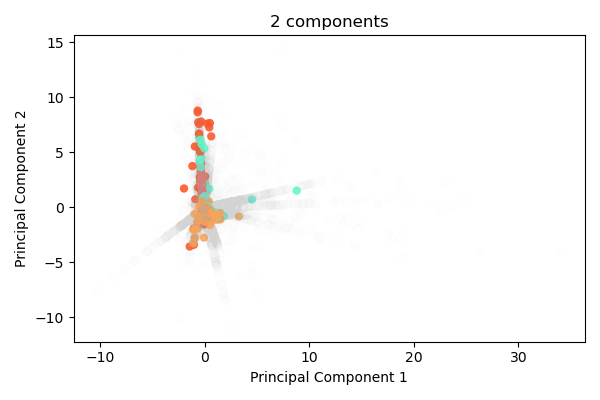

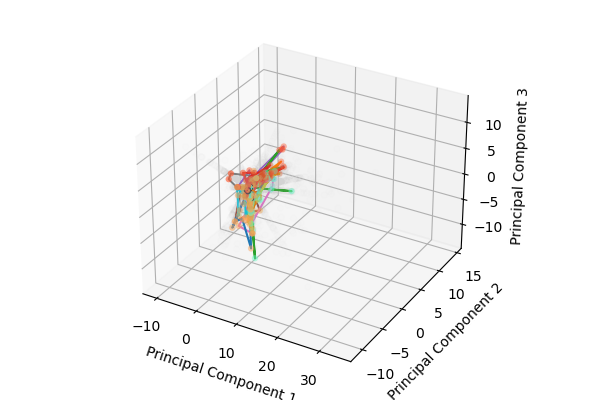

scan: 2    #cells: 22


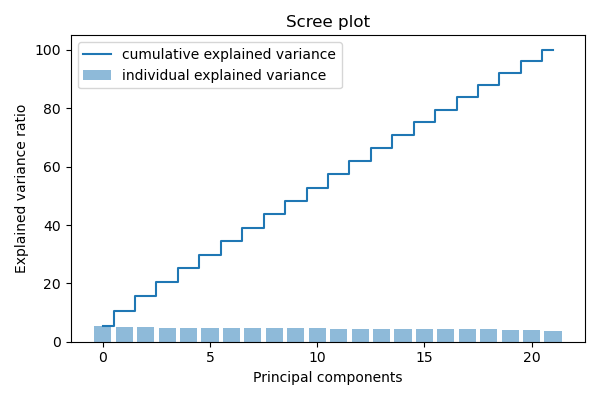

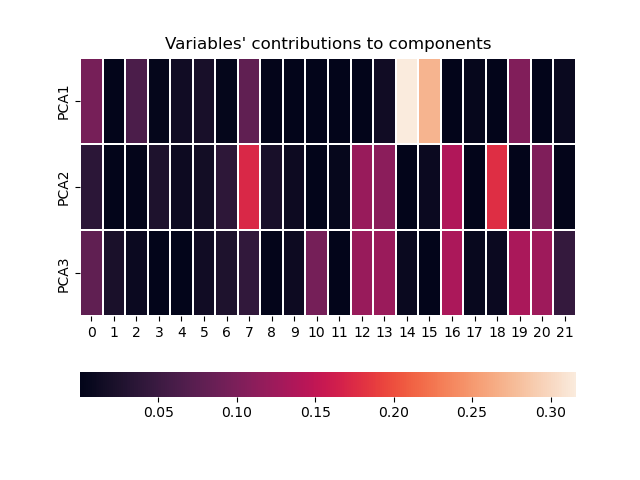

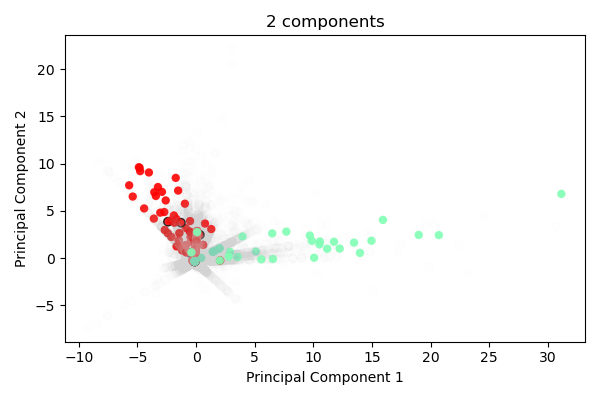

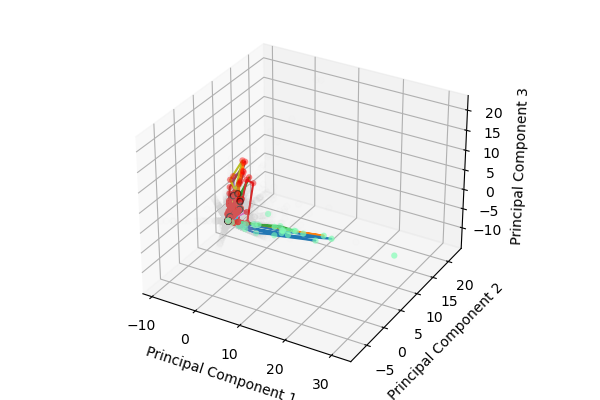

scan: 3    #cells: 22


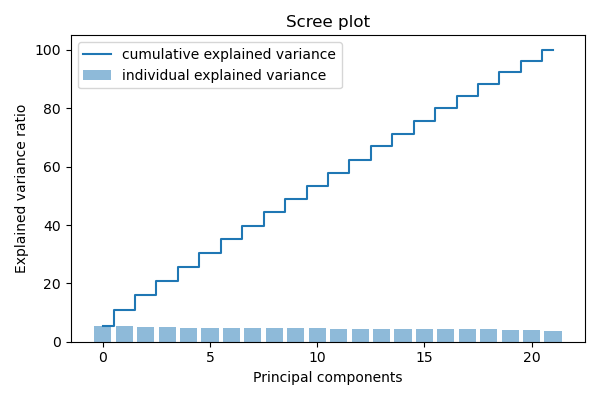

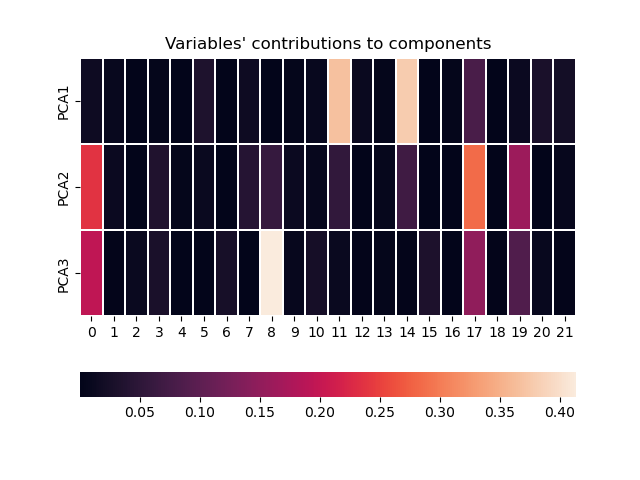

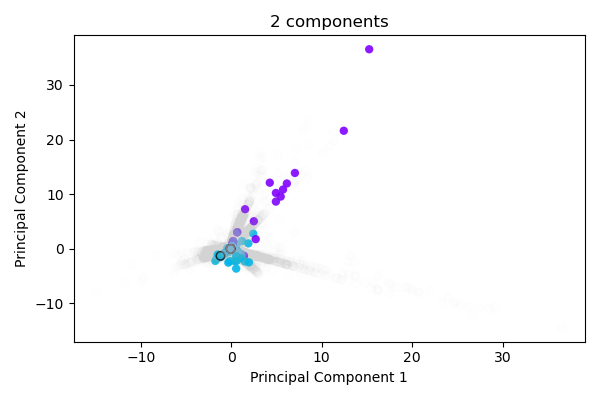

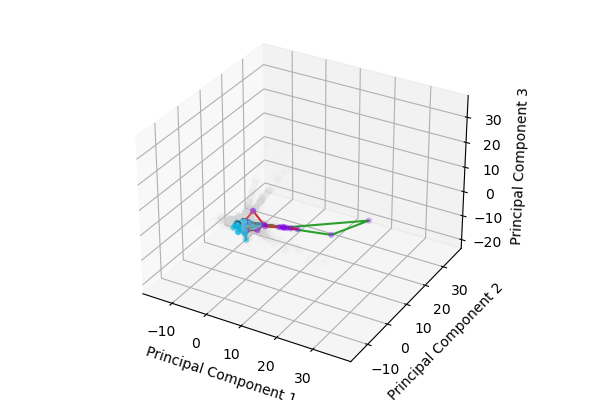

scan: 4    #cells: 12


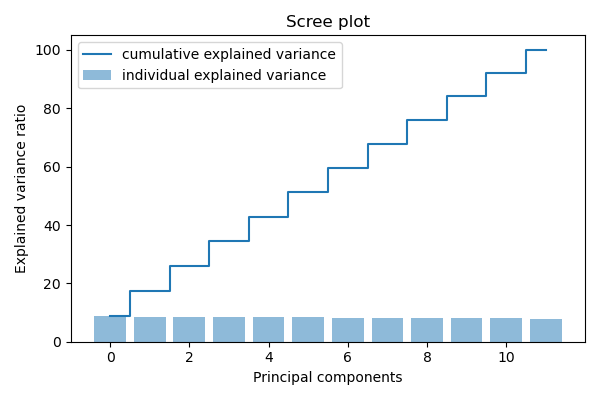

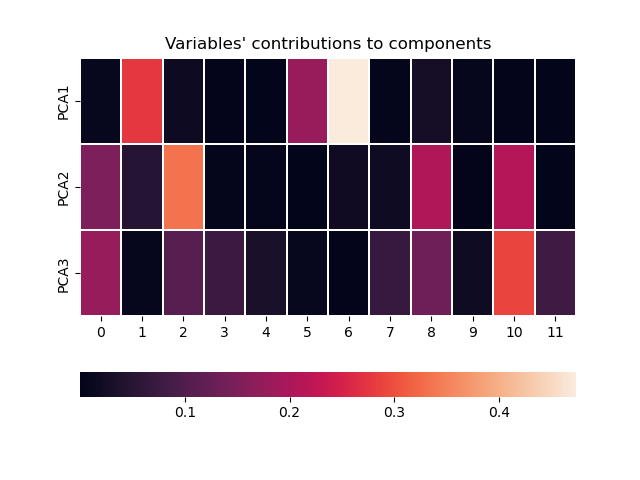

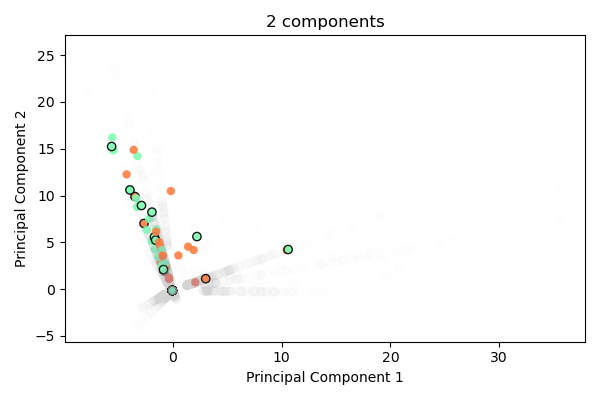

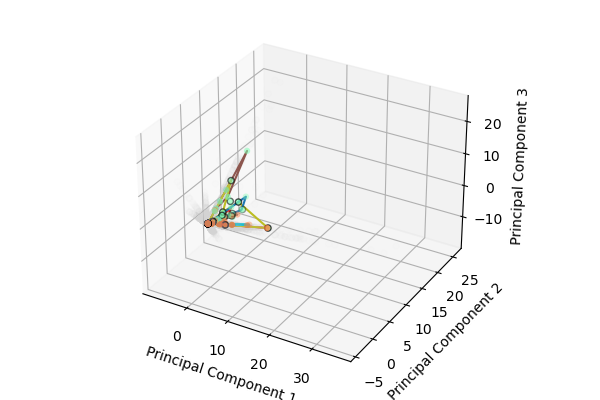

In [108]:
fig.clf()
plt.close()

Ypca = [] # one for each scan
for scan_id,scantraces in enumerate(traces): # by scan
    print("scan:",scan_id, "   #cells:",len(scantraces)) # N-dimensions
    scantraces = np.array(scantraces)
    # Standardize traces to help PCA yield a feature subspace maximizing the variance along the axes
    scantraces_std = StandardScaler().fit_transform(scantraces.T)
    # print(scantraces_std)
    
    # print('NumPy covariance matrix: \n%s' %np.cov(scantraces_std.T))
    cor_mat2 = np.corrcoef(scantraces)
    eig_vals, eig_vecs = np.linalg.eig(cor_mat2)
    # print('Eigenvectors \n%s' %eig_vecs)
    # print('\nEigenvalues \n%s' %eig_vals)
    # Make a list of (eigenvalue, eigenvector) tuples
    eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
    # Sort the (eigenvalue, eigenvector) tuples from high to low
    eig_pairs.sort(key=lambda x: x[0], reverse=True)
    tot = sum(eig_vals)
    var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
    cum_var_exp = np.cumsum(var_exp)
    
    plt.figure(figsize=(6, 4))
    plt.title("Scree plot")
    plt.bar(range(len(scantraces)), var_exp, alpha=0.5, align='center', label='individual explained variance')
    plt.step(range(len(scantraces)), cum_var_exp, where='mid', label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

    # matrix_w = np.hstack((eig_pairs[0][1].reshape(4,1), eig_pairs[1][1].reshape(4,1)))
    # print('Matrix W:\n', matrix_w)

    sklearn_pca = sklearnPCA(n_components=3)
    Y_sklearn = sklearn_pca.fit_transform(scantraces_std)
    Ypca.append( Y_sklearn )

    plt.figure()
    plt.title("Variables' contributions to components")
    _ = sns.heatmap(sklearn_pca.components_**2,
                 yticklabels=["PCA"+str(x) for x in range(1,sklearn_pca.n_components_+1)],
                 xticklabels=list(range(len(scantraces))),
                 linewidths=0.05,
                 cbar_kws={"orientation": "horizontal"})
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.title("2 components")
    plt.scatter(Y_sklearn[:,0], Y_sklearn[:,1], c=ecolors[scan_id], edgecolors=scolors[scan_id])
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.tight_layout()
    plt.show()

    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(projection='3d')
    for linestart,lineend in elines[scan_id]:
        ax.plot(Y_sklearn[linestart:lineend,0], Y_sklearn[linestart:lineend,1], Y_sklearn[linestart:lineend,2])
    ax.scatter(Y_sklearn[:,0], Y_sklearn[:,1], Y_sklearn[:,2], c=ecolors[scan_id], edgecolors=scolors[scan_id])
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    plt.tight_layout()
    plt.show()


#### Testing cluster manifolds
To detemine if events from a cluster belonged to the same manifold, we determined how closely their trajectories overlapped in the reduced dimensional space of PCA by measuring the [Haussdorf distance](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.directed_hausdorff.html) between pairs of state sequences (pairs of events) within a cluster containing several events.     
To establish the significance of these distances, we compared them to the distances between surrogate trajectories obtained by shuffling (100 times) the original trajectories.

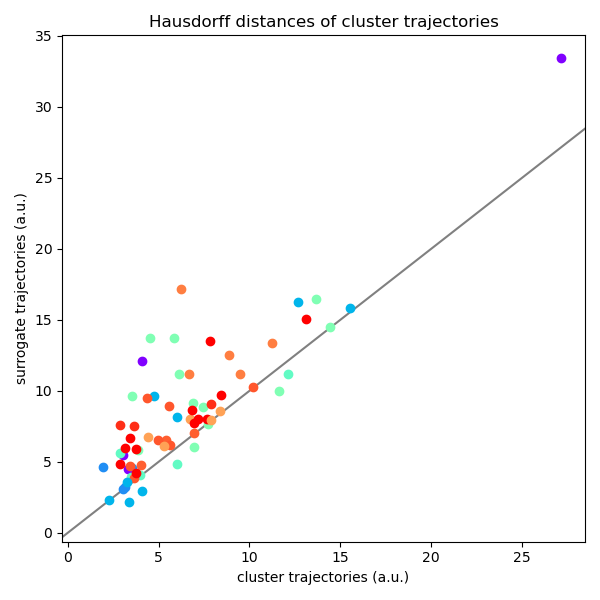

In [107]:
from scipy.spatial.distance import directed_hausdorff

# trajectories
hausdorff_trajectories = [None for i in range(5)] # list of dictionaries (below)
hausdorff_surrogates = [None for i in range(5)]
for scan_id in range(5):
    zippedlinescolors = sorted(zip(elines[scan_id],elinescolors[scan_id]), key = lambda t: t[1])
    currentcolor = None
    clustertrajectories = {}
    clustersurrogates = {} 
    for iline,_ in enumerate(zippedlinescolors[:-1]):
        (linestart1,lineend1),linecolor1 = zippedlinescolors[iline]
        (linestart2,lineend2),linecolor2 = zippedlinescolors[iline+1]
        if not currentcolor:
            currentcolor = linecolor1
        if currentcolor != linecolor2:
            currentcolor = linecolor2
            continue
        # trajectories
        u = np.array([ Ypca[scan_id][linestart1:lineend1,0], Ypca[scan_id][linestart1:lineend1,1], Ypca[scan_id][linestart1:lineend1,2] ]).T
        v = np.array([ Ypca[scan_id][linestart2:lineend2,0], Ypca[scan_id][linestart2:lineend2,1], Ypca[scan_id][linestart2:lineend2,2] ]).T
        # print(u.shape)
        if to_hex(currentcolor) not in clustertrajectories.keys():
            clustertrajectories[to_hex(currentcolor)] = []
        clustertrajectories[to_hex(currentcolor)].append( max(directed_hausdorff(u, v)[0], directed_hausdorff(v, u)[0]) ) # symmetric

        # surrogates
        hdistances = []
        nprng = np.random.default_rng()
        for si in range(100):
            us = nprng.permuted( u, axis=1 )
            vs = nprng.permuted( v, axis=1 )
            hdistances.append( max(directed_hausdorff(us, vs)[0], directed_hausdorff(vs, us)[0]) )
        if to_hex(currentcolor) not in clustersurrogates.keys():
            clustersurrogates[to_hex(currentcolor)] = []
        clustersurrogates[to_hex(currentcolor)].append( np.mean(hdistances) ) # symmetric

        # storage
    hausdorff_trajectories[scan_id] = clustertrajectories
    hausdorff_surrogates[scan_id] = clustersurrogates

# print(hausdorff_trajectories)
# print()
# print(hausdorff_surrogates)

# plotting 
fig.clf()
plt.close()
plt.figure(figsize=(6, 6))
plt.title("Hausdorff distances of cluster trajectories")
plt.axline((1, 1), slope=1, c='gray', zorder=1)
for trajectoriesdist,surrogatesdist in zip(hausdorff_trajectories,hausdorff_surrogates):
    for (trcolor,trdist),(sucolor,sudist) in zip(trajectoriesdist.items(), surrogatesdist.items() ):
        plt.scatter(trdist, sudist, c=trcolor)
plt.xlabel('cluster trajectories (a.u.)')
plt.ylabel('surrogate trajectories (a.u.)')
plt.tight_layout()
plt.show()

---
## Combined functional/structural analysis
Cortical networks have been shown above to present fixed-point attractor dynamics.     
Do they also present the structure of attractor networks?     
The theoretical fingerprint of an attractor network (cit) is **strong interconnections between pattern completion units** (cores).

### Are cores more functionally connected?
How likely is that a core is functionally efficient to elicit a response in a core or others.

In [26]:
# efficacy probability as 1-lag correlations
core2core_efficacy = [] # probability
core2other_efficacy = []
other2core_efficacy = []
other2other_efficacy = []
for dyn_core in clusters_cores:
    dyn_core_indexes = [ophys_cell_ids.index(strid) for strid in dyn_core]
    dyn_other_indexes = list(set(ophys_cell_indexes).symmetric_difference(set(dyn_core_indexes)))
    # selection
    core2core_efficacy.extend( [conns for cid in functional_adjacency_matrix[dyn_core_indexes,:] for conns in cid[dyn_core_indexes]] )
    core2other_efficacy.extend( [conns for cid in functional_adjacency_matrix[dyn_core_indexes,:] for conns in cid[dyn_other_indexes]] )
    other2core_efficacy.extend( [conns for cid in functional_adjacency_matrix[dyn_other_indexes,:] for conns in cid[dyn_core_indexes]] )
    other2other_efficacy.extend( [conns for cid in functional_adjacency_matrix[dyn_other_indexes,:] for conns in cid[dyn_other_indexes]] )

print("    {:d} core2core 1-lag R: {:1.3f}±{:1.2f}".format(len(core2core_efficacy), np.mean(core2core_efficacy),np.std(core2core_efficacy)) )
print("    {:d} core2other 1-lag R: {:1.3f}±{:1.2f}".format(len(core2other_efficacy), np.mean(core2other_efficacy),np.std(core2other_efficacy)) )
print("    {:d} other2core 1-lag R: {:1.3f}±{:1.2f}".format(len(other2core_efficacy), np.mean(other2core_efficacy),np.std(other2core_efficacy)) )
print("    {:d} other2other 1-lag R: {:1.3f}±{:1.2f}".format(len(other2other_efficacy), np.mean(other2other_efficacy),np.std(other2other_efficacy)) )
# significativity
kwstat,pval = stats.kruskal(core2core_efficacy, other2other_efficacy)
print("    core-core vs other-other 1-lag R Kruskal-Wallis test results:",kwstat,pval)
d,_ = stats.ks_2samp(core2core_efficacy, other2other_efficacy) # non-parametric measure of effect size [0,1]
print('    Kolmogorov-Smirnov Effect Size: %.3f' % d)
kwstat,pval = stats.kruskal(core2core_efficacy, core2other_efficacy)
print("    core-core vs core-other 1-lag R Kruskal-Wallis test results:",kwstat,pval)
d,_ = stats.ks_2samp(core2core_efficacy, core2other_efficacy) # non-parametric measure of effect size [0,1]
print('    Kolmogorov-Smirnov Effect Size: %.3f' % d)
kwstat,pval = stats.kruskal(core2core_efficacy, other2core_efficacy)
print("    core-core vs other-core 1-lag R Kruskal-Wallis test results:",kwstat,pval)
d,_ = stats.ks_2samp(core2core_efficacy, other2core_efficacy) # non-parametric measure of effect size [0,1]
print('    Kolmogorov-Smirnov Effect Size: %.3f' % d)
# all spine volumes by type
fig, ax = plt.subplots()
xs = np.random.normal(0, 0.04, len(core2core_efficacy))
plt.scatter(xs, core2core_efficacy, edgecolor='forestgreen', facecolor=('#228B224d'))
xs = np.random.normal(1, 0.04, len(core2other_efficacy))
plt.scatter(xs, core2other_efficacy, edgecolor='forestgreen', facecolor=('#228B224d'))
xs = np.random.normal(2, 0.04, len(other2core_efficacy))
plt.scatter(xs, other2core_efficacy, edgecolor='silver', facecolor=('#C0C0C04d'))
xs = np.random.normal(3, 0.04, len(other2other_efficacy))
plt.scatter(xs, other2other_efficacy, edgecolor='silver', facecolor=('#C0C0C04d'))
vp = ax.violinplot([core2core_efficacy,core2other_efficacy,other2core_efficacy,other2other_efficacy], [0,1,2,3], widths=0.3, showextrema=False, showmedians=True)
for pc in vp['bodies']:
    pc.set_edgecolor('black')
for pc in vp['bodies'][0:1]:
    pc.set_facecolor('#228B224d')
for pc in vp['bodies'][1:]:
    pc.set_facecolor('#D3D3D34d')
vp['cmedians'].set_color('orange')
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylabel('Efficacy (1-lag R)')
plt.xticks([0, 1, 2, 3], ["core-core\n(n={:d})".format(len(core2core_efficacy)), "core-other\n(n={:d})".format(len(core2other_efficacy)),"other-core\n(n={:d})".format(len(other2core_efficacy)),"other-other\n(n={:d})".format(len(other2other_efficacy))])
fig.savefig(exp_path+'/results/global_cores_others_efficacy.png', transparent=True, dpi=1500)
# fig.savefig(exp_path+'/results/global_cores_others_efficacy.svg', transparent=True)
plt.close()
fig.clf()

    5 core2core 1-lag R: 0.008±0.01
    31 core2other 1-lag R: 0.002±0.01
    31 other2core 1-lag R: 0.001±0.01
    221 other2other 1-lag R: 0.001±0.01
    core-core vs other-other 1-lag R Kruskal-Wallis test results: 2.713829201243022 0.09948193770081533
    Kolmogorov-Smirnov Effect Size: 0.507
    core-core vs core-other 1-lag R Kruskal-Wallis test results: 1.2567808404129257 0.26226131429195515
    Kolmogorov-Smirnov Effect Size: 0.484
    core-core vs other-core 1-lag R Kruskal-Wallis test results: 2.0780709153843926 0.1494289205199293
    Kolmogorov-Smirnov Effect Size: 0.548


---
## Mixing structural and dynamical analyses results to characterize core connectivity

Here, we collect the evidence contrasting the hypothesis that core neurons are strongly connected.   
We tested two fundamental attractor-driven assumptions:
- synapses between cores are more numerous and stronger compared to others   
- circuits made by cores involve more recursive connections toward cores

We can take the **number** and **volume** of post-synaptic spines as proxy for their functional efficacy. 

But two-photon imaged neurons are few (N=112), and core neurons even fewer (3 to 8 per cluster, 35 total). Therefore their count of (proofread) spines leads to underpowered statistics.    
We took three inclusive solutions: 
- we lowered the threshold for core identification to a minimum (participation to 60% of the events)
- we did not differentiate spines based on their point of contact (e.g. axo-somatic, axo-dendritic, axo-axonic, etc)
- we considered the number of spines to and from all neurons that were not part of the two-photon imaged dataset (based on the total count of spines, which lacks the proofread volume of the spines). 

### Core vs other to/from all spine number and volume (panel 2A)
We want to know whether cores and others differ globally in terms of their spines.    
Knowing the global properties of cores is relevant to assess the significance of the (underpowered) subsequent statistics limited to core vs other spine volume.

In [32]:
print("... postsynaptic spines on cores or others from all sources in the EM volume")
all2core_spine_vol = [] # µm3
core2all_spine_vol = []
all2other_spine_vol = []
other2all_spine_vol = []

all2core_spine_num = [] # num
core2all_spine_num = []
all2other_spine_num = []
other2all_spine_num = []
norm_all2core_spine_num = 0.0 # normalized num
norm_core2all_spine_num = 0.0
norm_all2other_spine_num = 0.0
norm_other2all_spine_num = 0.0

set_ids = set(ophys_cell_ids)
for dyn_core_ids in clusters_cores:
    dyn_other_ids = set_ids.symmetric_difference(dyn_core_ids)
    # searching
    
    all2core_synapse_df = syn_df.query(f'(post_root_id in {list(dyn_core_ids)})')
    if not all2core_synapse_df.empty:
        all2core_spine_num.extend( all2core_synapse_df.groupby('post_root_id').size() )
        norm_all2core_spine_num += all2core_synapse_df.groupby('post_root_id').size().sum()/(syn_df.shape[0]*len(list(dyn_core_ids))) # normalized by source*target

    all2other_synapse_df = syn_df.query(f'(post_root_id in {list(dyn_other_ids)})')
    if not all2other_synapse_df.empty:
        all2other_spine_num.extend( all2other_synapse_df.groupby('post_root_id').size() )
        norm_all2other_spine_num += all2other_synapse_df.groupby('post_root_id').size().sum()/(syn_df.shape[0]*len(list(dyn_other_ids)))

    core2all_synapse_df = syn_df.query(f'(pre_root_id in {list(dyn_core_ids)})')
    if not core2all_synapse_df.empty:
        core2all_spine_num.extend( core2all_synapse_df.groupby('pre_root_id').size() )
        norm_core2all_spine_num += core2all_synapse_df.groupby('pre_root_id').size().sum()/(syn_df.shape[0]*len(list(dyn_core_ids)))

    other2all_synapse_df = syn_df.query(f'(pre_root_id in {list(dyn_other_ids)})')
    if not other2all_synapse_df.empty:
        other2all_spine_num.extend( other2all_synapse_df.groupby('pre_root_id').size() )
        norm_other2all_spine_num += other2all_synapse_df.groupby('pre_root_id').size().sum()/(syn_df.shape[0]*len(list(dyn_other_ids)))

    # id, pre_root_id, post_root_id, cleft_vx, spine_vol_um3
    all2core_synapse_df = syn_spines_df.query(f'(post_root_id in {list(dyn_core_ids)})')
    if not all2core_synapse_df.empty:
        all2core_spine_vol.extend( all2core_synapse_df['spine_vol_um3'].tolist() )
    all2other_synapse_df = syn_spines_df.query(f'(post_root_id in {list(dyn_other_ids)})')
    if not all2other_synapse_df.empty:
        all2other_spine_vol.extend( all2other_synapse_df['spine_vol_um3'].tolist() )
    core2all_synapse_df = syn_spines_df.query(f'(pre_root_id in {list(dyn_core_ids)})')
    if not core2all_synapse_df.empty:
        core2all_spine_vol.extend( core2all_synapse_df['spine_vol_um3'].tolist() )
    other2all_synapse_df = syn_spines_df.query(f'(pre_root_id in {list(dyn_other_ids)})')
    if not other2all_synapse_df.empty:
        other2all_spine_vol.extend( other2all_synapse_df['spine_vol_um3'].tolist() )
        
# number description
print("    all2core spines number: {:1.3f}±{:1.2f} ".format(np.mean(all2core_spine_num),np.std(all2core_spine_num)) )
print("    core2all spines number: {:1.3f}±{:1.2f} ".format(np.mean(core2all_spine_num),np.std(core2all_spine_num)) )
print("    all2other spines number: {:1.3f}±{:1.2f} ".format(np.mean(all2other_spine_num),np.std(all2other_spine_num)) )
print("    other2all spines number: {:1.3f}±{:1.2f} ".format(np.mean(other2all_spine_num),np.std(other2all_spine_num)) )
# number significativity
kwstat,pval = stats.kruskal(all2core_spine_num, all2other_spine_num)
print("    all-core vs all-other spine number Kruskal-Wallis test results:",kwstat,pval)
d,_ = stats.ks_2samp(all2core_spine_num, all2other_spine_vol) # non-parametric measure of effect size [0,1]
print('    Kolmogorov-Smirnov Effect Size: %.3f' % d)
kwstat,pval = stats.kruskal(core2all_spine_num, other2all_spine_num)
print("    core-all vs other-all spine number Kruskal-Wallis test results:",kwstat,pval)
d,_ = stats.ks_2samp(core2all_spine_num, other2all_spine_num) # non-parametric measure of effect size [0,1]
print('    Kolmogorov-Smirnov Effect Size: %.3f' % d)

# plot
fig, ax = plt.subplots()
xs = np.random.normal(1, 0.04, len(core2all_spine_num))
plt.scatter(xs, core2all_spine_num, edgecolor='forestgreen', facecolor=('#228B224d'))
xs = np.random.normal(2, 0.04, len(other2all_spine_num))
plt.scatter(xs, other2all_spine_num, edgecolor='silver', facecolor=('#D3D3D34d'))
xs = np.random.normal(3, 0.04, len(all2core_spine_num))
plt.scatter(xs, all2core_spine_num, edgecolor='forestgreen', facecolor=('#228B224d'))
xs = np.random.normal(4, 0.04, len(all2other_spine_num))
plt.scatter(xs, all2other_spine_num, edgecolor='silver', facecolor=('#D3D3D34d'))
vp = ax.violinplot([core2all_spine_num,other2all_spine_num,all2core_spine_num,all2other_spine_num], widths=0.15, showextrema=False, showmedians=True)
for pc in vp['bodies']:
    pc.set_edgecolor('black')
for pc,cb in zip(vp['bodies'],['#228B224d','#D3D3D34d','#228B224d','#D3D3D34d']):
    pc.set_facecolor(cb)
vp['cmedians'].set_color('orange')
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylabel('Spine number per cell')
plt.yscale('log')
plt.xticks([1,2,3,4], ["core-all", "other-all", "all-core", "all-other"])
fig.savefig(exp_path+'/results/global_all_cores_others_spine_num.svg', transparent=True)
plt.close()
fig.clf()

# normalized spine number by type
x = np.array(["all-core", "all-other", "core-all", "other-all"])
y = np.array([norm_all2core_spine_num, norm_all2other_spine_num, norm_core2all_spine_num, norm_other2all_spine_num])
fig, ax = plt.subplots()
plt.bar(x, y, color=['forestgreen','silver','forestgreen','silver'])
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylabel('Normalized number of spines')
fig.savefig(exp_path+'/results/global_all_cores_others_spine_normnum.svg', transparent=True)
fig.clf()
plt.close()

print()
print("... postsynaptic spines on cores or others from sources in the EM volume (proofread with measured volume)")
# volume description
print("    {:d} all2core spines, volume: {:1.3f}±{:1.2f} µm3".format(len(all2core_spine_vol), np.mean(all2core_spine_vol),np.std(all2core_spine_vol)) )
# print("    "+str(stats.describe(all2core_spine_vol)) )
print("    {:d} core2all spines, volume: {:1.3f}±{:1.2f} µm3".format(len(core2all_spine_vol), np.mean(core2all_spine_vol),np.std(core2all_spine_vol)) )
# print("    "+str(stats.describe(all2core_spine_vol)) )
print("    {:d} all2other spines, volume: {:1.3f}±{:1.2f} µm3".format(len(all2other_spine_vol), np.mean(all2other_spine_vol),np.std(all2other_spine_vol)) )
# print("    "+str(stats.describe(all2other_spine_vol)) )
print("    {:d} other2all spines, volume: {:1.3f}±{:1.2f} µm3".format(len(other2all_spine_vol), np.mean(other2all_spine_vol),np.std(other2all_spine_vol)) )
# print("    "+str(stats.describe(all2other_spine_vol)) )
# volume significativity
kwstat,pval = stats.kruskal(all2core_spine_vol, all2other_spine_vol)
print("    all-core vs all-other spine volume Kruskal-Wallis test results:",kwstat,pval)
d,_ = stats.ks_2samp(all2core_spine_vol, all2other_spine_vol) # non-parametric measure of effect size [0,1]
print('    Kolmogorov-Smirnov Effect Size: %.3f' % d)
kwstat,pval = stats.kruskal(core2all_spine_vol, other2all_spine_vol)
print("    core-all vs other-all spine volume Kruskal-Wallis test results:",kwstat,pval)
d,_ = stats.ks_2samp(core2all_spine_vol, other2all_spine_vol) # non-parametric measure of effect size [0,1]
print('    Kolmogorov-Smirnov Effect Size: %.3f' % d)

# plot
fig, ax = plt.subplots()
xs = np.random.normal(1, 0.04, len(core2all_spine_vol))
plt.scatter(xs, core2all_spine_vol, edgecolor='forestgreen', facecolor=('#228B224d'))
xs = np.random.normal(2, 0.04, len(other2all_spine_vol))
plt.scatter(xs, other2all_spine_vol, edgecolor='silver', facecolor=('#D3D3D34d'))
xs = np.random.normal(3, 0.04, len(all2core_spine_vol))
plt.scatter(xs, all2core_spine_vol, edgecolor='forestgreen', facecolor=('#228B224d'))
xs = np.random.normal(4, 0.04, len(all2other_spine_vol))
plt.scatter(xs, all2other_spine_vol, edgecolor='silver', facecolor=('#D3D3D34d'))
vp = ax.violinplot([core2all_spine_vol,other2all_spine_vol,all2core_spine_vol,all2other_spine_vol], widths=0.15, showextrema=False, showmedians=True)
for pc in vp['bodies']:
    pc.set_edgecolor('black')
for pc,cb in zip(vp['bodies'],['#228B224d','#D3D3D34d','#228B224d','#D3D3D34d']):
    pc.set_facecolor(cb)
vp['cmedians'].set_color('orange')
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylabel('Spine Volume (µm^3)')
plt.xticks([1,2,3,4], ["core-all\n(n={:d})".format(len(core2all_spine_vol)), "other-all\n(n={:d})".format(len(other2all_spine_vol)), "all-core\n(n={:d})".format(len(all2core_spine_vol)), "all-other\n(n={:d})".format(len(all2other_spine_vol))])
fig.savefig(exp_path+'/results/global_all_cores_others_spine_vol.svg', transparent=True)
plt.close()
fig.clf()

... postsynaptic spines on cores or others from all sources in the EM volume
    all2core spines number: 2578.667±129.02 
    core2all spines number: 3.000±1.63 
    all2other spines number: 2648.575±1062.79 
    other2all spines number: 28.699±33.34 
    all-core vs all-other spine number Kruskal-Wallis test results: 0.0007119870133439304 0.9787125047199344
    Kolmogorov-Smirnov Effect Size: 1.000
    core-all vs other-all spine number Kruskal-Wallis test results: 4.363720373994353 0.03671204604075655
    Kolmogorov-Smirnov Effect Size: 0.630

... postsynaptic spines on cores or others from sources in the EM volume (proofread with measured volume)
    7 all2core spines, volume: 0.055±0.05 µm3
    0 core2all spines, volume: nan±nan µm3
    443 all2other spines, volume: 0.072±0.07 µm3
    302 other2all spines, volume: 0.077±0.07 µm3
    all-core vs all-other spine volume Kruskal-Wallis test results: 0.7116957092670682 0.39888145165554234
    Kolmogorov-Smirnov Effect Size: 0.328
    co

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: Data passed to ks_2samp must not be empty

### Core vs others  
The number of cores and non-cores for each cluster is different. Therefore we have to normalize this count to evaluate.

For each set of reproducible cluster we count:    
- the number of synapses made by a cell type (core or not) towards others, weighted by the squared number of target cells    
    - the expectation is that core-to-core and core-to-other synapses should be numerous in order to pull the dynamics
- the post-synaptic spine volume of synapses made by a cell type (core or not) towards others.   
    - the expectation is that core-to-core and core-to-other spines should be larger in order to pull the dynamics

**Synapses between core neurons of each cluster are less than every other combination.**    
Note that the resulting normalized synapse counts (for the others) check with the network density.

In [ ]:
# the density of the directed graph.
network_density = dgraph.density(loops=True)
print("... network density (ratio between the edges present and the maximum number of edges that the graph can contain):", network_density )
# spine number
core2core_spine_num = 0.0 # to be normalized
core2other_spine_num = 0.0
other2core_spine_num = 0.0
other2other_spine_num = 0.0
# spine volume
core2core_spine_vol = [] # µm3
core2other_spine_vol = []
other2core_spine_vol = []
other2other_spine_vol = []

set_ids = set(ophys_cell_ids)
cluster_colors = [color for color in cluster_color_array if color!='gray']
for cluster_k,dyn_core_ids in zip(cluster_colors,clusters_cores):
    if cluster_k=='gray':
        continue
    dyn_other_ids = set_ids.symmetric_difference(dyn_core_ids)
    
    # spine number
    core2core_synapse_df = syn_spines_df.query(f'(pre_root_id in {list(dyn_core_ids)}) and (post_root_id in {list(dyn_core_ids)})')
    core2core_spine_num += len(core2core_synapse_df['id'].tolist())/(len(dyn_core_ids)*len(dyn_core_ids)) # normalized by source*target

    core2other_synapse_df = syn_spines_df.query(f'(pre_root_id in {list(dyn_core_ids)}) and (post_root_id in {list(dyn_other_ids)})')
    core2other_spine_num += len(core2other_synapse_df['id'].tolist())/(len(dyn_core_ids)*len(dyn_other_ids)) 

    other2core_synapse_df = syn_spines_df.query(f'(pre_root_id in {list(dyn_other_ids)}) and (post_root_id in {list(dyn_core_ids)})')
    other2core_spine_num += len(other2core_synapse_df['id'].tolist())/(len(dyn_core_ids)*len(dyn_other_ids)) 
    
    other2other_synapse_df = syn_spines_df.query(f'(pre_root_id in {list(dyn_other_ids)}) and (post_root_id in {list(dyn_other_ids)})')
    other2other_spine_num += len(other2other_synapse_df['id'].tolist())/(len(dyn_other_ids)*len(dyn_other_ids)) 

    # spine volume
    # id, pre_root_id, post_root_id, cleft_vx, spine_vol_um3
    core2core_synapse_df = syn_spines_df.query(f'(pre_root_id in {list(dyn_core_ids)}) and (post_root_id in {list(dyn_core_ids)})')
    if not core2core_synapse_df.empty:
        core2core_spine_vol.extend( core2core_synapse_df['spine_vol_um3'].tolist() )
    
    core2other_synapse_df = syn_spines_df.query(f'(pre_root_id in {list(dyn_core_ids)}) and (post_root_id in {list(dyn_other_ids)})')
    if not core2other_synapse_df.empty:
        core2other_spine_vol.extend( core2other_synapse_df['spine_vol_um3'].tolist() )
    
    other2core_synapse_df = syn_spines_df.query(f'(pre_root_id in {list(dyn_other_ids)}) and (post_root_id in {list(dyn_core_ids)})')
    if not other2core_synapse_df.empty:
        other2core_spine_vol.extend( other2core_synapse_df['spine_vol_um3'].tolist() )
 
    other2other_synapse_df = syn_spines_df.query(f'(pre_root_id in {list(dyn_other_ids)}) and (post_root_id in {list(dyn_other_ids)})')
    if not other2other_synapse_df.empty:
        other2other_spine_vol.extend( other2other_synapse_df['spine_vol_um3'].tolist() )

# description
# number
print("... Normalized number of spines")
print("    {:f} core2core normalized spines number".format((core2core_spine_num)) )
print("    {:f} core2other normalized spines number".format((core2other_spine_num)) )
print("    {:f} other2core normalized spines number".format((other2core_spine_num)) )
print("    {:f} other2other normalized spines number".format((other2other_spine_num)) )

# spines
print("... Spine volumes")
print("    {:d} core2core spines, volume: {:1.3f}±{:1.2f} µm3".format(len(core2core_spine_vol), np.mean(core2core_spine_vol),np.std(core2core_spine_vol)) )
# print("    "+str(stats.describe(core2core_spine_vol)) )
print("    {:d} core2other spines, volume: {:1.3f}±{:1.2f} µm3".format(len(core2other_spine_vol), np.mean(core2other_spine_vol),np.std(core2other_spine_vol)) )
# print("    "+str(stats.describe(core2other_spine_vol)) )
print("    {:d} other2core spines, volume: {:1.3f}±{:1.2f} µm3".format(len(other2core_spine_vol), np.mean(other2core_spine_vol),np.std(other2core_spine_vol)) )
# print("    "+str(stats.describe(other2core_spine_vol)) )
print("    {:d} other2other spines, volume: {:1.3f}±{:1.2f} µm3".format(len(other2other_spine_vol), np.mean(other2other_spine_vol),np.std(other2other_spine_vol)) )
# print("    "+str(stats.describe(other2other_spine_vol)) )

# significativity
# this is just to test the significativity if the number of samples was correct
kwstat,pval = stats.kruskal(other2core_spine_vol, other2other_spine_vol)
print("   core vs other spine size Kruskal-Wallis test results:",kwstat,pval)

# plotting
# all spine number by type
x = np.array(["core-core", "core-other", "other-core", "other-other"])
y = np.array([core2core_spine_num, core2other_spine_num, other2core_spine_num, other2other_spine_num])
fig, ax = plt.subplots()
plt.bar(x, y, color=['forestgreen','forestgreen','silver','silver'])
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylabel('Normalized number of spines')
fig.savefig(exp_path+'/results/global_cores_others_spine_num.svg', transparent=True)
fig.clf()
plt.close()

# normalized spine number by type
x = np.array(["all\ncore", "all\nother", "core\nall", "other\nall", "core\ncore", "core\nother", "other\ncore", "other\nother"])
y = np.array([norm_all2core_spine_num, norm_all2other_spine_num, norm_core2all_spine_num, norm_other2all_spine_num, core2core_spine_num, core2other_spine_num, other2core_spine_num, other2other_spine_num])
fig, ax = plt.subplots()
plt.bar(x, y, width=0.5, color=['forestgreen','silver','forestgreen','silver','forestgreen','forestgreen','silver','silver'])
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylabel('Connection probability (relative spine freq.)')
fig.savefig(exp_path+'/results/global_all_cores_others_spine_normnum.svg', transparent=True)
fig.clf()
plt.close()


# all spine volumes by type
fig, ax = plt.subplots()
# xs = np.random.normal(0, 0.04, len(core2core_spine_vol))
# plt.scatter(xs, core2core_spine_vol, edgecolor='forestgreen', facecolor=('#228B224d'))
xs = np.random.normal(1, 0.04, len(core2other_spine_vol))
plt.scatter(xs, core2other_spine_vol, edgecolor='forestgreen', facecolor=('#228B224d'))
xs = np.random.normal(2, 0.04, len(other2core_spine_vol))
plt.scatter(xs, other2core_spine_vol, edgecolor='silver', facecolor=('#D3D3D34d'))
xs = np.random.normal(3, 0.04, len(other2other_spine_vol))
plt.scatter(xs, other2other_spine_vol, edgecolor='silver', facecolor=('#D3D3D34d'))
# vp = ax.violinplot([core2core_spine_vol,core2other_spine_vol,other2core_spine_vol,other2other_spine_vol], [0,1,2,3], widths=0.3, showextrema=False, showmedians=True)
vp = ax.violinplot([core2other_spine_vol,other2core_spine_vol,other2other_spine_vol], [1,2,3], widths=0.3, showextrema=False, showmedians=True)
for pc in vp['bodies']:
    pc.set_edgecolor('black')
for pc in vp['bodies'][0:1]:
    pc.set_facecolor('#228B224d')
for pc in vp['bodies'][1:]:
    pc.set_facecolor('#D3D3D34d')
vp['cmedians'].set_color('orange')
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylabel('Spine Volume (µm^3)')
plt.xticks([0, 1, 2, 3], [ "core-core\n(n={:d})".format(len(core2core_spine_vol)),"core-other\n(n={:d})".format(len(core2other_spine_vol)),"other-core\n(n={:d})".format(len(other2core_spine_vol)),"other-other\n(n={:d})".format(len(other2other_spine_vol))])
fig.savefig(exp_path+'/results/global_cores_others_spine_vol.svg', transparent=True)
fig.clf()
plt.close()

### Non-Ca-imaged and outside EM volume inputs (panel 2AB)

Core responses could be due to non-imaged and outside volume sources. How can we rule this out (or reduce our lack of knowledge)?   
We can ask *Are there more or stronger spines made by non-imaged neurons (either local or far) on cores or others?*   
We have this information since we know the cell ID of all somas in the volume. We can take the spines having presynaptic ID different from the known Ca-imaged IDs or different from the somas within the EM volume.

### Are core more mutually connected than others?

We started by asking whether a global measure such as assortativity - - gives a clear summary of mutuality between all cores.

In [ ]:
print('... assortativity')
print('    preparing vertex labels for cores and others')
dgraph.vs["ophys_cell_id"] = ophys_cell_ids
is_id_core = np.array( [0] * len(ophys_cell_ids) )
is_id_core[core_indexes] = 1
dgraph.vs["is_core"] = is_id_core.tolist()
pyc_ca_syn_df = syn_df.query(f'(pre_root_id in {ophys_cell_ids}) and (post_root_id in {ophys_cell_ids})')
is_syn_core = np.array( [0] * len(pyc_ca_syn_df) )
for cid in [item for sublist in clusters_cores for item in sublist]:
    is_syn_core[pyc_ca_syn_df['pre_root_id'] == cid] = 1
dgraph.es["is_core"] = is_syn_core.tolist()

# is a preference for a network's nodes to attach to others that are similar in some way
print("    overall:", dgraph.assortativity_nominal("is_core", directed=True) )
# cores degree distro vs others degree distro
# biological networks typically show negative assortativity, or disassortative mixing, or disassortativity, as high degree nodes tend to attach to low degree nodes.
print("    assortativity degree:", dgraph.assortativity_degree(directed=True) )


### 3-Motif connectivity of cores and others (panel 2D)

This measure of the network reports the participation of cores (or non-cores) in triplet motifs.    
Note that the triplets are not exclusively made of cores (or non-cores).

In [ ]:
# For each set of reproducible cluster cores we count their connectivity motifs.
set_indexes = set(ophys_cell_indexes)
for dyn_core_ids in clusters_cores:
    dyn_core_indexes = set([ophys_cell_ids.index(strid) for strid in dyn_core_ids])
    dyn_other_indexes = set_indexes.symmetric_difference(dyn_core_indexes)
    for mclass, mlist in motif_vertices.items():
        for mtriplet in mlist:
            intersection_cores = len(list(dyn_core_indexes.intersection(mtriplet)))
            intersection_others = len(list(dyn_other_indexes.intersection(mtriplet)))
            global_structural_motif_cores[mclass] += intersection_cores
            global_structural_motif_others[mclass] += intersection_others

fig = plt.figure()
plt.bar(global_structural_motif_cores.keys(), global_structural_motif_cores.values(), color='forestgreen')
plt.ylabel('cores occurrences')
plt.yscale('log')
plt.ylim([0.7,plt.ylim()[1]])
plt.xlabel('motifs types')
fig.savefig(exp_path+'/results/global_motifs_cores.svg', transparent=True)
plt.close()
fig.clear()
fig.clf()
fig = plt.figure()
plt.bar(global_structural_motif_others.keys(), global_structural_motif_others.values(), color='silver')
plt.ylabel('non-cores occurrences')
plt.yscale('log')
plt.ylim([0.7,plt.ylim()[1]])
plt.xlabel('motifs types')
fig.savefig(exp_path+'/results/global_motifs_others.svg', transparent=True)
plt.close()
fig.clear()
fig.clf()
print("... saved mutual connectivity of cores and others")

In [ ]:
# dgraph is already defined from the structural_analysis included file
print("    graph diameter (#vertices):", dgraph.diameter(directed=True, unconn=True, weights=None))
print("    graph average path length (#vertices):", dgraph.average_path_length(directed=True, unconn=True))

## Centrality of cores

If cores are not more mutually connected compared to others, then what is their characterizing feature?    
In the cells above, we saw indications of more interconnections between cores and others than within the same type.     
This could hint at some form of centrality.

### Degree centrality of cores is not different from others (panel 2E)

In [ ]:
print('... degree centrality')
degree_centrality_cores = dgraph.degree(core_indexes, mode='out', loops=True)
degree_centrality_others = dgraph.degree(other_indexes, mode='out', loops=True)
# description
print("    cores: "+str(stats.describe(degree_centrality_cores)) )
print("    others: "+str(stats.describe(degree_centrality_others)) )
# significativity
print("    Welch t test:  %.3f p= %.3f" % stats.ttest_ind(degree_centrality_cores, degree_centrality_others, equal_var=False))
d,_ = stats.ks_2samp(degree_centrality_cores, degree_centrality_others) # non-parametric measure of effect size [0,1]
print('    Kolmogorov-Smirnov Effect Size: %.3f' % d)

fig, ax = plt.subplots()
xs = np.random.normal(1, 0.04, len(degree_centrality_cores))
plt.scatter(xs, degree_centrality_cores, alpha=0.3, c='forestgreen')
xs = np.random.normal(2, 0.04, len(degree_centrality_others))
plt.scatter(xs, degree_centrality_others, alpha=0.3, c='silver')
vp = ax.violinplot([degree_centrality_cores,degree_centrality_others], widths=0.15, showextrema=False, showmedians=True)
for pc in vp['bodies']:
    pc.set_edgecolor('black')
for pc,cb in zip(vp['bodies'],['#228B224d','#D3D3D34d']):
    pc.set_facecolor(cb)
vp['cmedians'].set_color('orange')
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylabel('Degree')
plt.xticks([1, 2], ["core\n(n={:d})".format(len(degree_centrality_cores)), "other\n(n={:d})".format(len(degree_centrality_others))])
fig.savefig(exp_path+'/results/global_cores_others_degree.svg', transparent=True)
plt.close()
fig.clf()

### Betweenness cenrality of cores is not different from others (panel 2F)

In [ ]:
print('... betweenness')
cores_betweenness = np.array(dgraph.betweenness(vertices=core_indexes, directed=True))
others_betweenness = np.array(dgraph.betweenness(vertices=other_indexes, directed=True))
print("    cores: "+str(stats.describe(cores_betweenness)) )
print("    others: "+str(stats.describe(others_betweenness)) )
# significativity
print("    Welch t test:  %.3f p= %.3f" % stats.ttest_ind(cores_betweenness, others_betweenness, equal_var=False))
d,_ = stats.ks_2samp(cores_betweenness, others_betweenness) # non-parametric measure of effect size [0,1]
print('    Kolmogorov-Smirnov Effect Size: %.3f' % d)

fig, ax = plt.subplots()
xs = np.random.normal(1, 0.04, len(cores_betweenness))
plt.scatter(xs, cores_betweenness, alpha=0.3, c='forestgreen')
xs = np.random.normal(2, 0.04, len(others_betweenness))
plt.scatter(xs, others_betweenness, alpha=0.3, c='silver')
vp = ax.violinplot([cores_betweenness,others_betweenness], widths=0.15, showextrema=False, showmedians=True)
for pc in vp['bodies']:
    pc.set_edgecolor('black')
for pc,cb in zip(vp['bodies'],['#228B224d','#D3D3D34d']):
    pc.set_facecolor(cb)
vp['cmedians'].set_color('orange')
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.yscale('log')
# plt.ylim([0.00001,plt.ylim()[1]])
plt.ylabel('Betweenness')
plt.xticks([1, 2], ["core\n(n={:d})".format(len(cores_betweenness)), "other\n(n={:d})".format(len(others_betweenness))])
fig.savefig(exp_path+'/results/global_cores_others_betweenness.svg', transparent=True)
plt.close()
fig.clf()

### Hub scores of cores is not different from others (panel 2G)

In [ ]:
print("... authority score")
# what is the overlap of cores and hubs?
# Hub
authority_scores = np.array(dgraph.authority_score(weights=None, scale=True, return_eigenvalue=False))
authority_scores_cores = authority_scores[core_indexes]
authority_scores_others = authority_scores[other_indexes]
print("    authority cores: "+str(stats.describe(authority_scores_cores)) )
print("    authority others: "+str(stats.describe(authority_scores_others)) )
# significativity
print("    Kruskal-Wallis test:  %.3f p= %.3f" % stats.ttest_ind(authority_scores_cores, authority_scores_others))
d,_ = stats.ks_2samp(authority_scores_cores, authority_scores_others) # non-parametric measure of effect size [0,1]
print('    Kolmogorov-Smirnov Effect Size: %.3f' % d)
# all eccentricity by type
fig, ax = plt.subplots()
xs = np.random.normal(1, 0.04, len(authority_scores_cores))
plt.scatter(xs, authority_scores_cores, alpha=0.3, c='forestgreen')
xs = np.random.normal(2, 0.04, len(authority_scores_others))
plt.scatter(xs, authority_scores_others, alpha=0.3, c='silver')
vp = ax.violinplot([authority_scores_cores,authority_scores_others], widths=0.15, showextrema=False, showmedians=True)
for pc in vp['bodies']:
    pc.set_edgecolor('black')
for pc,cb in zip(vp['bodies'],['#228B224d','#D3D3D34d']):
    pc.set_facecolor(cb)
vp['cmedians'].set_color('orange')
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylabel('Hub score')
plt.xticks([1, 2], ["core\n(n={:d})".format(len(authority_scores_cores)), "other\n(n={:d})".format(len(authority_scores_others))])
fig.savefig(exp_path+'/results/global_cores_others_authority_score.svg', transparent=True)
plt.close()
fig.clf()

print("... hub score")
# what is the overlap of cores and hubs?
# Hub
hub_scores = np.array(dgraph.hub_score(weights=None, scale=True, return_eigenvalue=False))
hub_scores_cores = hub_scores[core_indexes]
hub_scores_others = hub_scores[other_indexes]
print("    hub cores: "+str(stats.describe(hub_scores_cores)) )
print("    hub others: "+str(stats.describe(hub_scores_others)) )
# significativity
print("    Kruskal-Wallis test:  %.3f p= %.3f" % stats.ttest_ind(hub_scores_cores, hub_scores_others))
d,_ = stats.ks_2samp(hub_scores_cores, hub_scores_others) # non-parametric measure of effect size [0,1]
print('    Kolmogorov-Smirnov Effect Size: %.3f' % d)
# all eccentricity by type
fig, ax = plt.subplots()
xs = np.random.normal(1, 0.04, len(hub_scores_cores))
plt.scatter(xs, hub_scores_cores, alpha=0.3, c='forestgreen')
xs = np.random.normal(2, 0.04, len(hub_scores_others))
plt.scatter(xs, hub_scores_others, alpha=0.3, c='silver')
vp = ax.violinplot([hub_scores_cores,hub_scores_others], widths=0.15, showextrema=False, showmedians=True)
for pc in vp['bodies']:
    pc.set_edgecolor('black')
for pc,cb in zip(vp['bodies'],['#228B224d','#D3D3D34d']):
    pc.set_facecolor(cb)
vp['cmedians'].set_color('orange')
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylabel('Hub score')
plt.xticks([1, 2], ["core\n(n={:d})".format(len(hub_scores_cores)), "other\n(n={:d})".format(len(hub_scores_others))])
fig.savefig(exp_path+'/results/global_cores_others_hub_score.svg', transparent=True)
plt.close()
fig.clf()

## Cores control the flow of cortical activity

So far, we used structural (graph) measures of neurons selected by looking at their reproducibility (a form of regular activity). In a sense, we were already crossing structural and dynamical information about the network.    

However, we could push this further.    

### Structural underpinnings of clusters (panel 2H)

What is the origin of pattern reproducibility?    
We can look at **how** the underlying connectivity structure supports each events activities.    

We can consider each event as a _network flow problem_, in which the activity can be transferred through cells along the available connections.    

For each event, we compute the max flow between the cells IDs according to their firing sequence.      
**Do core neurons sustain more flow compared to others?**

And we also consider 

In [ ]:
# each edge has a capacity and each edge receives a flow. 
# The amount of flow on an edge cannot exceed the capacity of the edge.
# therefore, edges with high capacity will be more important for the flow.
# here we test the hypothesis that edges towards cores have higher capacity
# or that the sum of edges towards cores have a higher total capacity
cell_total_capacity = {cid:list() for cid in ophys_cell_ids}
edges_sourcing = {cid:0 for cid in ophys_cell_ids}
edges_targeting = {cid:0 for cid in ophys_cell_ids}

for cluster_k,events_cellids in sorted_events_cidlist.items():
    if cluster_k == 'gray':
        continue

    for vnt in events_cellids:
        for posi,vidj in enumerate(vnt[1:]):
            vidi = vnt[posi] # enumerate will go from 0
            # print(vidi, vidj)

            # check beginning and end are not the same
            if dgraph.vs.find(ophys_cell_id=vidi).index == dgraph.vs.find(ophys_cell_id=vidj).index:
                continue
            # # check there is a path between the two
            # if len(spinesgraph.get_all_shortest_paths(spinesgraph.vs.find(name=vidi).index, to=spinesgraph.vs.find(name=vidj).index, weights=None, mode='out'))>0:
            #     continue

            # Take the maximum flow between the previous and next vertices
            mfres = dgraph.maxflow(dgraph.vs.find(ophys_cell_id=vidi).index, dgraph.vs.find(ophys_cell_id=vidj).index)
            # print(mfres)
            # returns a tuple containing the following:
            # graph - the graph on which this flow is defined
            # value - the value (capacity) of the maximum flow between the given vertices
            # flow - the flow values on each edge. For directed graphs, this is simply a list where element i corresponds to the flow on edge i.
            # cut - edge IDs in the minimal cut corresponding to the flow.
            # partition - vertex IDs in the parts created after removing edges in the cut
            # es - an edge selector restricted to the edges in the cut.

            # we get a flow value for each edge contributing to the flow.
            # source
            mfres_value = mfres.value
            if vidi in np.array(ophys_cell_ids)[core_indexes]:
                mfres_value /= len(core_indexes)
            else:
                mfres_value /= len(other_indexes)
            cell_total_capacity[vidi].append(mfres_value)
            # target
            mfres_value = mfres.value
            if vidj in np.array(ophys_cell_ids)[core_indexes]:
                mfres_value /= len(core_indexes)
            else:
                mfres_value /= len(other_indexes)
            cell_total_capacity[vidj].append(mfres_value)
            
            # Iterate over the edges identified by the flow.
            # count the edges sourcing from cores, and those targeting cores. Which is more?
            for edge in mfres.es:
                sourceid = int(dgraph.vs[edge.source]['ophys_cell_id'])
                targetid = int(dgraph.vs[edge.target]['ophys_cell_id'])
                if sourceid in cell_total_capacity.keys():
                    edges_sourcing[sourceid] +=1 # just count
                if targetid in cell_total_capacity.keys():
                    edges_targeting[targetid] +=1 # just count

# Flow
# print(cell_total_capacity)
flowvalue_cores = []
for cid in np.array(ophys_cell_ids)[core_indexes]:
    flowvalue_cores.extend(cell_total_capacity[cid])
flowvalue_others = []
for cid in np.array(ophys_cell_ids)[other_indexes]:
    flowvalue_others.extend(cell_total_capacity[cid])

# description
print("    Flow cores: "+str(stats.describe(flowvalue_cores)) )
print("    Flow others: "+str(stats.describe(flowvalue_others)) )
# significativity
print("    Welch t test:  %.3f p= %.3f" % stats.ttest_ind(flowvalue_cores, flowvalue_others, equal_var=False))
d,_ = stats.ks_2samp(flowvalue_cores, flowvalue_others) # non-parametric measure of effect size [0,1]
print('    Kolmogorov-Smirnov Effect Size: %.3f' % d)

fig, ax = plt.subplots()
xs = np.random.normal(1, 0.04, len(flowvalue_cores))
plt.scatter(xs, flowvalue_cores, alpha=0.3, c='forestgreen')
xs = np.random.normal(2, 0.04, len(flowvalue_others))
plt.scatter(xs, flowvalue_others, alpha=0.3, c='silver')
vp = ax.violinplot([flowvalue_cores,flowvalue_others], widths=0.15, showextrema=False, showmeans=True)
for pc in vp['bodies']:
    pc.set_edgecolor('black')
for pc,cb in zip(vp['bodies'],['#228B224d','#D3D3D34d']):
    pc.set_facecolor(cb)
vp['cmeans'].set_color('orange')
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylabel('Normalized flow value')
plt.xticks([1, 2], ["core\n(n={:d})".format(len(flowvalue_cores)), "other\n(n={:d})".format(len(flowvalue_others))])
fig.savefig(exp_path+'/results/global_cores_others_flowvalue.svg', transparent=True)
plt.close()
fig.clf()

print()
# Cuts
# print(edges_sourcing)
# print(edges_targeting)
flowcuts_core_sources = []
flowcuts_core_targets = []
for cid in np.array(ophys_cell_ids)[core_indexes]:
    flowcuts_core_sources.append(edges_sourcing[cid]/len(core_indexes))
    flowcuts_core_targets.append(edges_targeting[cid]/len(core_indexes))
flowcuts_other_sources = []
flowcuts_other_targets = []
for cid in np.array(ophys_cell_ids)[other_indexes]:
    flowcuts_other_sources.append(edges_sourcing[cid]/len(other_indexes))
    flowcuts_other_targets.append(edges_targeting[cid]/len(other_indexes))

# description
print("    Cut edges sourcing from cores: "+str(stats.describe(flowcuts_core_sources)) )
print("    Cut edges targeting cores: "+str(stats.describe(flowcuts_core_targets)) )
print("    Cut edges sourcing from others: "+str(stats.describe(flowcuts_other_sources)) )
print("    Cut edges targeting others: "+str(stats.describe(flowcuts_other_targets)) )
# significativity
print("    Core targets vs sources Welch t test:  %.3f p= %.3f" % stats.ttest_ind(flowcuts_core_targets, flowcuts_core_sources, equal_var=False))
d,_ = stats.ks_2samp(flowcuts_core_targets, flowcuts_core_sources) # non-parametric measure of effect size [0,1]
print('    Kolmogorov-Smirnov Effect Size: %.3f' % d)

print("    Core targets vs Other targets Welch t test:  %.3f p= %.3f" % stats.ttest_ind(flowcuts_core_targets, flowcuts_other_targets, equal_var=False))
d,_ = stats.ks_2samp(flowcuts_core_targets, flowcuts_other_targets) # non-parametric measure of effect size [0,1]
print('    Kolmogorov-Smirnov Effect Size: %.3f' % d)

fig, ax = plt.subplots()
xs = np.random.normal(1, 0.04, len(flowcuts_core_sources))
plt.scatter(xs, flowcuts_core_sources, alpha=0.3, c='forestgreen')
xs = np.random.normal(2, 0.04, len(flowcuts_core_targets))
plt.scatter(xs, flowcuts_core_targets, alpha=0.3, c='forestgreen')
xs = np.random.normal(3, 0.04, len(flowcuts_other_sources))
plt.scatter(xs, flowcuts_other_sources, alpha=0.3, c='silver')
xs = np.random.normal(4, 0.04, len(flowcuts_other_targets))
plt.scatter(xs, flowcuts_other_targets, alpha=0.3, c='silver')
vp = ax.violinplot([flowcuts_core_sources,flowcuts_core_targets,flowcuts_other_sources,flowcuts_other_targets], widths=0.15, showextrema=False, showmeans=True)
for pc in vp['bodies']:
    pc.set_edgecolor('black')
for pc in vp['bodies'][0:2]:
    pc.set_facecolor('#228B224d')
for pc in vp['bodies'][2:]:
    pc.set_facecolor('#D3D3D34d')
vp['cmeans'].set_color('orange')
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylabel('Normalized edges in the cut')
plt.xticks([1, 2, 3, 4], ["core as\nsource", "core as\ntarget", "other as\nsource", "other as\ntarget"])
fig.savefig(exp_path+'/results/global_cores_others_cutvalue.svg', transparent=True)
plt.close()
fig.clf()



### Cores are targets of multiple paths

If cores are more often than others part of the paths, it means that they might not be central by virtue of their degree, but by how many event trajectory path (not just any path as in the betweenness, or hubness) pass through them.     
More in detail, cores are important because they are more often the target of cut flow edges. The **pagerank** - where a node rank is proportional to the total rank of the other nodes pointing to it - is a way to measure it.

In [ ]:
print('... PageRank centrality')
pagerank_cores = np.array(dgraph.personalized_pagerank(vertices=core_indexes, directed=True, damping=0.85, reset="is_core"))
pagerank_others = np.array(dgraph.personalized_pagerank(vertices=other_indexes, directed=True, damping=0.85, reset="is_core"))
# description
print("    cores: "+str(stats.describe(pagerank_cores)) )
print("    others: "+str(stats.describe(pagerank_others)) )
# significativity
print("    Kruskal-Wallis test:  %.3f p= %.3f" % stats.kruskal(pagerank_cores, pagerank_others))
d,_ = stats.ks_2samp(pagerank_cores, pagerank_others) # non-parametric measure of effect size [0,1]
print('    Kolmogorov-Smirnov Effect Size: %.3f' % d)

fig, ax = plt.subplots()
xs = np.random.normal(1, 0.04, len(pagerank_cores))
plt.scatter(xs, pagerank_cores, alpha=0.3, c='forestgreen')
xs = np.random.normal(2, 0.04, len(pagerank_others))
plt.scatter(xs, pagerank_others, alpha=0.3, c='silver')
vp = ax.violinplot([pagerank_cores,pagerank_others], widths=0.15, showextrema=False, showmedians=True)
for pc in vp['bodies']:
    pc.set_edgecolor('black')
for pc,cb in zip(vp['bodies'],['#228B224d','#D3D3D34d']):
    pc.set_facecolor(cb)
vp['cmedians'].set_color('orange')
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylabel('PageRank')
plt.xticks([1, 2], ["core\n(n={:d})".format(len(pagerank_cores)), "other\n(n={:d})".format(len(pagerank_others))])
fig.savefig(exp_path+'/results/global_cores_others_pagerank.svg', transparent=True)
plt.close()
fig.clf()

## Relationship between structural and dynamical cores

### Hierarchical modularity
The log-log linear relationship between Clustering coefficient and degree is plotted in the file `hierarchical modularity.png` (and .svg) produced by the `structural_analysis.py` and already stored in the `results` folder.

### Bow-tie structure of modules
Local bow-ties analysis as in Fujita et al. 2019.
Identify communities based on (multiple trials) random walks as information flows.    
With very sparsely connected networks, as MICrONS, the library igraph finds only one module (see [here](https://stackoverflow.com/questions/20364939/community-detection-with-infomap-algorithm-producing-one-massive-module)). Using the same algorithm (with teleportation) from the InfoMap authors (see [here](https://mapequation.github.io/infomap/python/)).


In [ ]:
from infomap import Infomap # with teleportation to ensure no local solution
im = Infomap(no_self_links=True, flow_model="directed", seed=2**32-2, prefer_modular_solution=True)
im.add_networkx_graph( dgraph.to_networkx() ) # infomap accepts only networkx format
print("    starting infomap analysis")
im.run()
print(f"    found {im.num_top_modules} modules with codelength: {im.codelength:.4f}  entropy: {im.entropy_rate:.4f}")
previous_id = 1
communities_tot = []
communities_lens = []
community = []
structural_cores = []
for node_id, module_id in sorted(im.modules, key=lambda x: x[1]):
    if module_id>previous_id: # simple module handling
        community_graph = dgraph.subgraph(community) # community contains the indexes in dgraph
        imcommunity = Infomap(no_self_links=True, flow_model="directed", seed=2**32-2, prefer_modular_solution=True, silent=True)
        imcommunity.add_networkx_graph( community_graph.to_networkx() )
        imcommunity.run()
        # unspecific submodule specification
        if imcommunity.num_non_trivial_top_modules > 2:
            communities_lens.append(len(community))
        communities_tot.append(len(community))
        # get central community cores
        community_cores = []
        for imnode, immodules in imcommunity.get_multilevel_modules().items():
            if immodules[0]==1: # only the center
                community_cores.append(imnode)
        structural_cores.append(community_cores)
        # simple module handling
        previous_id=module_id
        community = []
    # print(node_id, module_id)
    community.append(node_id)
print("    bow-tie score:", len(communities_lens)/len(communities_tot))
print("    communities lens:",stats.describe(communities_lens))


### (OPTIONAL) Random rewiring to test bow-tie score

The EM data gives a certain bow-tie score.    
To see whether the score can be improved or worsen by different connectivities, we can rewire at random (easy), and study their statistics.   
**Uncomment the lines below to run the (rather long) rewiring tests.**

In [ ]:
# rewired_bowtie_score = {}
# for rewireprob in np.linspace(0.01, 0.05, num=10):
#     print("    \nrewiring probability:",rewireprob)
#     rewired_bowtie_score[rewireprob] = []
#
#     for trial in range(0,10):
#         rewired_graph = dgraph.copy()
#
#         rewired_graph.rewire_edges(prob=rewireprob, loops=False, multiple=True) # in place!
#
#         # Clustering Coefficient of only excitatory cells
#         local_clustering_coefficients = np.array(rewired_graph.transitivity_local_undirected(vertices=None, mode="zero"))
#         # plot
#         paramsfit = [2, 1.05] # 334 EM-only all proofread
#         pfit = powerlaw(degrees, *paramsfit)
#         fig = plt.figure()
#         summer = mpcm.summer
#         plt.scatter( degrees,local_clustering_coefficients, marker='o', facecolor='#111111', s=50, edgecolors='none', alpha=0.5) #
#         plt.plot(degrees,pfit,c='k')
#         plt.yscale('log')
#         plt.xscale('log')
#         ax = plt.gca()
#         ax.spines['top'].set_visible(False)
#         ax.spines['right'].set_visible(False)
#         plt.ylabel('LCC')
#         plt.xlabel('degree')
#         plt.tick_params(axis='both', bottom='on', top='on', left='off', right='off')
#         plt.tight_layout()
#         #fig.savefig(exp_path+'/results/rewiring/hierarchical_modularity'+str(rewireprob)+str(trial)+'.png', transparent=True, dpi=900)
#         fig.savefig(exp_path+'/results/rewiring/hierarchical_modularity'+str(rewireprob)+"_"+str(trial)+'.svg', transparent=True)
#         plt.close()
#         fig.clf()
#
#         # Local bow-ties analysis as in FujitaKichikawaFujiwaraSoumaIyetomi2019
#         from infomap import Infomap
#         im = Infomap(silent=True, no_self_links=True, flow_model="directed", seed=2**32-1, core_loop_limit=10, prefer_modular_solution=True, inner_parallelization=True, num_trials=10)
#         im.add_networkx_graph( rewired_graph.to_networkx() ) # infomap accepts only networkx format
#         im.run()
#         previous_id = 1
#         communities_tot = []
#         communities_lens = []
#         community = []
#         for node_id, module_id in sorted(im.modules, key=lambda x: x[1]):
#             if module_id>previous_id: # simple module handling
#                 community_graph = rewired_graph.subgraph(community) # community contains the indexes in rewired_graph
#                 imcommunity = Infomap(no_self_links=True, flow_model="directed", seed=2**32-1, core_loop_limit=10, prefer_modular_solution=True, silent=True, num_trials=10)
#                 imcommunity.add_networkx_graph( community_graph.to_networkx() )
#                 imcommunity.run()
#                 if imcommunity.num_non_trivial_top_modules > 2:
#                     communities_lens.append(len(community))
#                 communities_tot.append(len(community))
#                 previous_id=module_id
#                 community = []
#             community.append(node_id)
#         if len(communities_tot)<5:
#             continue
#         bowtie_score = len(communities_lens)/len(communities_tot)
#         print("    trial:", trial, "score:",bowtie_score)
#         rewired_bowtie_score[rewireprob].append( bowtie_score )
#
# for rwiredk, rewiredv in rewired_bowtie_score.items():
#     print("dgraph rewired with prob:",rwiredk)
#     print("    bow-tie score avg:", stats.describe(rewiredv))


### Overlap between structural and dynamical clusters

Check the consistency of our hypothesis chain by looking at the overlap between dynamically-identified core neurons – those reliably participating in multiple clustered population events – and structurally-identified core neurons – those repetitively found in bow-tie modules.    
(it requires the file with dynamical cores)

In [ ]:
if os.path.exists('./results/clusters_cores.npy'):
    clusters_cores = np.load('./results/clusters_cores.npy', allow_pickle=True)
    print("... loaded:", clusters_cores.shape)
    # print(clusters_cores)
    # print(clusters_cores.shape)

    core_indexes = []
    other_indexes = []
    clusters_cores_indexes = []
    for dyn_core in clusters_cores:
        core_indexes.extend( [ophys_cell_ids.index(strid) for strid in dyn_core] )
        clusters_cores_indexes.append( [ophys_cell_ids.index(strid) for strid in dyn_core] )
    core_indexes = np.unique(core_indexes)
    print("    # cores:",len(core_indexes))
    other_indexes = [i for i in range(len(ophys_cell_ids)) if i not in core_indexes]
    print("    # non-cores:",len(other_indexes))

    print("... overlap between structural cores and dynamical cores")
    # for each set of dynamical cores from a cluster
    # we compare it with all the sets of structral core nodes identified by the InfoMap (and take the max to avoid duplicates)
    overlapSD = {}
    overlap_ratio = []
    ccs_len = []
    scs_len = []
    for iccs,ccs in enumerate(clusters_cores_indexes):
        ccs_len.append(len(ccs))
        kccs = "{}_{}_".format(iccs,len(ccs))
        overlapSD[kccs+"lens"] = []
        overlapSD[kccs+"ratio"] = []
        for scs in structural_cores:
            scs_len.append(len(scs))
            overlapSD[kccs+"lens"].append( "{}/{}".format( len(set(ccs)&set(scs)), len(ccs) ) )
            overlapSD[kccs+"ratio"].append( len(set(ccs)&set(scs))/len(ccs) )
        # print(len(scs),len(ccs))
        # choose which structural_cores better matches
        index_max = max(range(len(overlapSD[kccs+"ratio"])), key=overlapSD[kccs+"ratio"].__getitem__)
        print(overlapSD[kccs+"ratio"][index_max], overlapSD[kccs+"lens"][index_max])
        overlap_ratio.append(overlapSD[kccs+"ratio"][index_max])
    print(stats.describe(overlap_ratio))

    # plot all ratio
    fig, ax = plt.subplots()
    xs = np.random.normal(1, 0.04, len(overlap_ratio))
    plt.scatter(xs, overlap_ratio, alpha=0.3, c='gray', edgecolors='none')
    vp = ax.violinplot([overlap_ratio], widths=0.15, showextrema=False, showmeans=True)
    for pc in vp['bodies']:
        pc.set_edgecolor('black')
    for pc,cb in zip(vp['bodies'],['black']):
        pc.set_facecolor(cb)
    vp['cmeans'].set_color('orange')
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.ylim([0,0.7])
    plt.ylabel('Overlap ratio')
    fig.set_figwidth(1.5)
    fig.tight_layout()
    fig.savefig('./results/dynamical_structural_cores.svg', transparent=True)
    plt.close()
    fig.clf()

---
## Supplementary figure 3
   
To have keep cores within the attractor framework, cores activity could be sustained by indirect synaptic feedback, through highly connected secondary paths.   
To back up the attractor idea, one would expect that core neurons would have shorter paths or cycles, compared to others. 

### Shortest paths of cores and others (panel S3A)

In [ ]:
print("... number of paths in a complete graph of the same size:", (np.math.factorial(112-2)*np.e))
print('... number of shortest paths between cores')
core_shortestpaths = []
for coreidx in core_indexes:
    othercores = list(core_indexes)
    othercores.remove(coreidx)
    shrtpth = dgraph.get_shortest_paths(coreidx, to=othercores, weights=None, mode='out', output='vpath')
    for strp in shrtpth:
        core_shortestpaths.append(len(strp))
other_shortestpaths = []
for otheridx in other_indexes:
    otherothers = list(other_indexes)
    otherothers.remove(otheridx)
    shrtpth = dgraph.get_shortest_paths(otheridx, to=otherothers, weights=None, mode='out', output='vpath')
    for strp in shrtpth:
        other_shortestpaths.append(len(strp))
print("    cores shortest paths: "+str(stats.describe(core_shortestpaths)) )
print("    others shortest paths: "+str(stats.describe(other_shortestpaths)) )
print("    equal variances? "+str(stats.levene(core_shortestpaths, other_shortestpaths)) )
# significativity
print("    Welch t test:  %.3f p= %.3f" % stats.ttest_ind(core_shortestpaths, other_shortestpaths, equal_var=False))
d,_ = stats.ks_2samp(core_shortestpaths, other_shortestpaths) # non-parametric measure of effect size [0,1]
print('    Kolmogorov-Smirnov Effect Size: %.3f' % d)
fig, ax = plt.subplots()
xs = np.random.normal(1, 0.04, len(core_shortestpaths))
plt.scatter(xs, core_shortestpaths, alpha=0.3, c='forestgreen')
xs = np.random.normal(2, 0.04, len(other_shortestpaths))
plt.scatter(xs, other_shortestpaths, alpha=0.3, c='silver')
vp = ax.violinplot([core_shortestpaths,other_shortestpaths], widths=0.15, showextrema=False, showmedians=True)
for pc in vp['bodies']:
    pc.set_edgecolor('black')
for pc,cb in zip(vp['bodies'],['#228B224d','#D3D3D34d']):
    pc.set_facecolor(cb)
vp['cmedians'].set_color('orange')
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylabel('Shortest path length')
plt.xticks([1, 2], ["core\n(n={:d})".format(len(core_shortestpaths)), "other\n(n={:d})".format(len(other_shortestpaths))])
fig.savefig(exp_path+'/results/global_cores_others_shortestpath.svg', transparent=True)
plt.close()
fig.clf()

### Cycles between cores or others (panel S3B)

Cycles are built starting from a core (or other) and iterating neighbors of different lenghts, where the last vertex is the starting one.

In [ ]:
print('... cycles')
# breadth first search of paths and unique cycles
def get_cycles(adj, paths, maxlen):
    # tracking the actual path length:
    maxlen -= 1
    nxt_paths = []
    # iterating over all paths:
    for path in paths['paths']:
        # iterating neighbors of the last vertex in the path:
        for nxt in adj[path[-1]]:
            # attaching the next vertex to the path:
            nxt_path = path + [nxt]
            if path[0] == nxt and min(path) == nxt:
                # the next vertex is the starting vertex, we found a cycle
                # we keep the cycle only if the starting vertex has the
                # lowest vertex id, to avoid having the same cycles
                # more than once
                paths['cycles'].append(nxt_path)
                # if you don't need the starting vertex
                # included at the end:
                # paths$cycles <- c(paths$cycles, list(path))
            elif nxt not in path:
                # keep the path only if we don't create
                # an internal cycle in the path
                nxt_paths.append(nxt_path)
    # paths grown by one step:
    paths['paths'] = nxt_paths
    if maxlen == 0:
        # the final return when maximum search length reached
        return paths
    else:
        # recursive return, to grow paths further
        return get_cycles(adj, paths, maxlen)
# Comparison of core based cycles vs other based cycles
maxlen = 10 # the maximum length to limit computation time
# creating an adjacency list
adj = [[n.index for n in v.neighbors()] for v in dgraph.vs]
# recursive search of cycles
# for each core vertex as candidate starting point
core_cycles = []
for start in core_indexes:
    core_cycles += get_cycles(adj,{'paths': [[start]], 'cycles': []}, maxlen)['cycles']
print("    # core-based cycles:", len(core_cycles) )
# count the length of loops involving 1 core
core_cycles_lens = [len(cycle) for cycle in core_cycles]
print("    core-based cycles length: "+str(stats.describe(core_cycles_lens)) )

other_cycles = []
for start in other_indexes:
    other_cycles += get_cycles(adj,{'paths': [[start]], 'cycles': []}, maxlen)['cycles']
print("    # other-based cycles:", len(other_cycles) )
# count the length of loops involving 1 core
other_cycles_lens = [len(cycle) for cycle in other_cycles]
print("    other-based cycles length: "+str(stats.describe(other_cycles_lens)) )

d,_ = stats.ks_2samp(core_cycles_lens, other_cycles_lens) # non-parametric measure of effect size [0,1]
print('    Kolmogorov-Smirnov Effect Size: %.3f' % d)
# all cycles by type
fig, ax = plt.subplots()
xs = np.random.normal(1, 0.04, len(core_cycles_lens))
plt.scatter(xs, core_cycles_lens, alpha=0.3, c='forestgreen')
xs = np.random.normal(2, 0.04, len(other_cycles_lens))
plt.scatter(xs, other_cycles_lens, alpha=0.3, c='silver')
bp = ax.boxplot([core_cycles_lens,other_cycles_lens], notch=0, sym='', showcaps=False, zorder=10)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylabel('Cycles length')
plt.xticks([1, 2], ["core\n(n={:d})".format(len(core_cycles_lens)), "other\n(n={:d})".format(len(other_cycles_lens))])
fig.savefig(exp_path+'/results/global_cores_others_cyclelens.png', transparent=True, dpi=1500)
plt.close()
fig.clf()

### Do the cores of each cluster form more cliques than others? (Panel S3C)

If the cores of each cluster are pattern completion units, they should participate in more cliques (set of vertices where an edge is present between any two of them) than other non-core neurons.

In [ ]:
cliques = dgraph.cliques(min=2)

cliques_cores = []
cliques_others = []

for cluster_cids in clustered_spectrums:
    cluster_core_indices = []
    # we take the index of the cell participating in this cluster
    cluster_indices = [ophys_cell_ids.index(strid) for strid in cluster_cids]
    # we take the cores of this cluster
    cluster_core_indices = list(set(core_indexes).intersection(cluster_indices))
    cluster_other_indices = list(set(other_indexes).intersection(cluster_indices))
    # we take the edges between the cores
    for clique in cliques:
        if set(clique).issubset(cluster_core_indices):
            cliques_cores.append(clique)
        if set(clique).issubset(cluster_other_indices):
            cliques_others.append(clique)
print(cliques_cores)
cores_cliques_count = len(cliques_cores)/len(core_indexes)
others_cliques_count = len(cliques_others)/len(other_indexes)

print("    cliques made by cores:",cores_cliques_count)
print("    cliques made by others:",others_cliques_count)

# print(core_edges)
x = np.array(["cores", "others"])
y = np.array([cores_cliques_count, others_cliques_count])
fig, ax = plt.subplots()
plt.bar(x, y, color=['forestgreen','silver'])
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylabel('Normalized count of cliques')
plt.xticks([0, 1], ["core\n(n={:.3f})".format(cores_cliques_count), "other\n(n={:.3f})".format(others_cliques_count)])
fig.savefig(exp_path+'/results/global_cores_others_cliques.svg', transparent=True)
plt.close()
fig.clf()
    

### Clusters of events are not reproducible trajectories of the population dynamics

Clusters of population events are found by correlating population vectors, which only retain the cell IDs while ignoring the time of firing.    
We can consider also time.

Each recorded frame (~67ms) is an instantaneous population state defined by all its cells (112 of them are known for their firing, the others are unkown).    
A sequence of population states is a trajectory in the population dynamical state space.    
In this space, clusters of reproducible population events are represented by reproducible trajectories. 

We can compare the event trajectories visited within a cluster by comparing their patterns.    
Events are made by cells firing (often multiple times) during the event interval, so each sequence is a 2D submatrix of the population rasterplot. This gives a measure of trajectory reproducibility. 

In [ ]:
# print(cluster_events_spiketrains) # already expressed in integer (ms)

print("... sequence internal consistency")

# cycle over clusters
for cluster_k, events_cellindexes in sorted_events_indexes.items():
    if cluster_k == 'gray':
        continue
    print()

    # We want to compare the trajectories of this cluster.
    # Trajectories should have same shape. We will subract them to get the difference (/num of events).
    
    # Finding the common-shape trajectory
    # n is the maximal number of cells participating to events in this cluster
    maxcells = max(events_cellindexes, key = lambda i: len(i))
    # m is the largest interval between the first min spiketrain and the last max spiketrain of all events in the cluster
    events_spiketrains = cluster_events_spiketrains[cluster_k]
    # print(events_spiketrains)
    maxinterval = 0 # 
    for evt_spktrains in events_spiketrains:
        mint = np.amin([x for xs in evt_spktrains for x in xs]) # for cases of just one spiketinme in list
        if isinstance(mint, list): mint = mint[0] # for cases of list
        maxt = np.amax([x for xs in evt_spktrains for x in xs])
        if isinstance(maxt, list): maxt = maxt[-1]
        if maxt-mint > maxinterval:
            maxinterval = maxt-mint
    print("    common trajectory pattern with n cells:", len(maxcells), " and m intervals:", maxinterval)
    
    # cluster trajectories, one per event, all same shape
    cluster_trajectories = []
    for evt_indexes,evt_spktrains in zip(events_cellindexes,events_spiketrains):
        # create empty trajectory of shape n cell, m interval
        trajectory = np.zeros((len(maxcells),maxinterval+1))
        mint = np.amin([x for xs in evt_spktrains for x in xs]) # take local mintime to find the trajectory m index
        if isinstance(mint, list): mint = mint[0] # for cases of just one spiketinme in list
        for ncell,spktrain in enumerate(evt_spktrains):
            trajectory[ncell][spktrain-mint] = 1
        cluster_trajectories.append(trajectory)
    
    # correlation between trajectories
    # very simple (probably too much) measure of trajectory correspondence
    trajR = []
    for itr,itrajectory in enumerate(cluster_trajectories):
        for jtr,jtrajectory in enumerate(cluster_trajectories):
            if itr!=jtr:
                trajR.append( np.nanmean(np.corrcoef(itrajectory,jtrajectory)) )
    print("    correlation across all trajectories: {:1.3f}±{:1.2f}".format(np.mean(trajR),np.std(trajR)))

    print("... searching for repeating sequences in the ordered firing of cell IDs")
    size = 2
    # size = 3
    cluster_sequences = [x for xs in events_cellindexes for x in xs]
    # print(cluster_sequences)
    windows = [
        tuple(window)
        for window in more_itertools.windowed(cluster_sequences, size)
    ]
    counter = collections.Counter(windows)
    for window, count in counter.items():
        if count > 1:
            print("   ",window, count)
            print(core_indexes)
        